# CUAI Advanced track 3월 IMC  
## - Laptop 가격 예측

## 1. 문제 정의
### - 제조사, 화면 크기, 해상도, CPU 등의 정보를 통해 laptop의 가격(price) 예측  
### - 변수 설명  
* Company: 제조사  
* Product: 모델명  
* TypeName: laptop의 분류 (Notebook, Gaming, Ultrabook, 2 in 1 Convertible, Netbook, Workstation)  
* Inches: 화면 크기  
* ScreenResolution: 화면 해상도  
* Cpu: CPU 종류  
* Ram: 메모리 용량  
* Memory: 저장장치
* Gpu: GPU 제조사, 상세정보  
* OpSys: OS 정보  
* Weight: laptop 무게
* price: 가격(target 변수)

## 2. 탐색적 데이터 분석

### 2-1 데이터 로드, 확인

In [1]:
# 필요한 라이브러리 로드
import pandas as pd
import numpy as np
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, skew
from scipy import stats
from sklearn.preprocessing import LabelEncoder

pd.options.display.max_columns = 40
warnings.filterwarnings('ignore')

In [2]:
# 데이터 로드
train = pd.read_csv('Adv_IMC_train.csv')

# 확인할 수 있는 최대 컬럼 수 설정
pd.options.display.max_columns = 40

print(train.shape)
train.head()

(1042, 12)


,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,price
0,HP,250 G6,Notebook,15.6,1366x768,Intel Core i5 7200U 2.5GHz,4GB,500GB HDD,Intel HD Graphics 620,No OS,1.86kg,393.9
1,Asus,X541NA (N3350/4GB/1TB/FHD/W10),Notebook,NaN,Full HD 1920x1080,Intel Celeron Dual Core N3350 1.1GHz,4GB,1TB HDD,Intel HD Graphics 500,Windows 10,2kg,344.0
2,HP,15-AC110nv (i7-6500U/6GB/1TB/Radeon,Notebook,15.6,1366x768,Intel Core i7 6500U 2.5GHz,6GB,1TB HDD,AMD Radeon R5 M330,Windows 10,2.19kg,764.0
3,Dell,Inspiron 7559,Gaming,15.6,IPS Panel Touchscreen / 4K Ultra HD 3840x2160,Intel Core i7 6700HQ 2.6GHz,16GB,128GB SSD + 1TB HDD,Nvidia GeForce GTX 960M,Windows 10,2.72kg,1099.0
4,Razer,Blade Stealth,Ultrabook,12.5,IPS Panel 4K Ultra HD / Touchscreen 3840x2160,Intel Core i7 7500U 2.5GHz,16GB,512GB SSD,Intel HD Graphics 620,Windows 10,1.29kg,1799.0


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1042 entries, 0 to 1041
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1042 non-null   object 
 1   Product           1042 non-null   object 
 2   TypeName          1042 non-null   object 
 3   Inches            1025 non-null   float64
 4   ScreenResolution  1042 non-null   object 
 5   Cpu               1042 non-null   object 
 6   Ram               1042 non-null   object 
 7   Memory            1042 non-null   object 
 8   Gpu               1042 non-null   object 
 9   OpSys             1042 non-null   object 
 10  Weight            1042 non-null   object 
 11  price             1042 non-null   float64
dtypes: float64(2), object(10)
memory usage: 97.8+ KB


In [4]:
# 결측치 확인
train.isnull().sum()

Company              0
Product              0
TypeName             0
Inches              17
ScreenResolution     0
Cpu                  0
Ram                  0
Memory               0
Gpu                  0
OpSys                0
Weight               0
price                0
dtype: int64

화면의 크기를 나타내는 inch 변수에 결측치가 존재  
* 이후 결측치 전처리 단계가 필요

### 2-2 탐색적 데이터 분석을 위한 전처리

In [5]:
# 데이터 변형을 위한 복사본 사용
train_data = train.copy()

train_data.describe(exclude='float')

,Company,Product,TypeName,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
count,1042,1042,1042,1042,1042,1042,1042,1042,1042,1042
unique,19,535,6,38,103,9,36,102,9,170
top,Lenovo,XPS 13,Notebook,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,2.2kg
freq,244,26,574,409,144,482,316,222,850,92


Category가 상대적으로 많은 Product, ScreenResolution, Cpu, Memory, Gpu, Weight의 전처리가 필요

**Product 변수 전처리**
* Inspiron, ProBook 같이 가장 앞에 나오는 제품명만 추출

In [6]:
train_data['Product'].str.split(' ').str[0].value_counts()

Inspiron          107
IdeaPad            71
ThinkPad           57
Aspire             48
ProBook            40
                 ... 
15-BW004nv          1
15-bw011nv          1
FX502VM-DM560T      1
FX503VM-E4007T      1
15-BW094nd          1
Name: Product, Length: 193, dtype: int64

In [7]:
# 공백과 '-'의 앞의 문자 추출
train_data['Product'] = train_data['Product'].str.split(' ').str[0]
train_data['Product'] = train_data['Product'].str.split('-').str[0]

# 제조사가 Asus, MSI, Lenovo, Acer, Mediacom, Vero일 경우에는 숫자 앞의 문자 추출
temp_list = []
for n in range(len(train_data)):
    if train_data.iloc[n]['Company'] in ['Asus', 'MSI', 'Lenovo', 'Acer', 'Mediacom', 'Vero'] and train_data.iloc[n]['Company'] != 'HP':
        product = train_data.iloc[n]['Product']
        num = re.findall('\d', product)
        if num != []:
            # 숫자 추출
            num = re.findall('\d', product)[0]
            result = product.split(num)[0]
        else:
            result = train_data.iloc[n]['Product']
    else:
        result = train_data.iloc[n]['Product']
    temp_list.append(result)

# dataframe에 추가
train_data['Product'] = pd.Series(temp_list)

**ScreenResolution 변수 전처리**
* HD, Full HD 등의 정보는 뒤의 픽셀수가 정보를 담고 있으므로 픽셀수 추출
* IPS Panel, Touchscreen은 의미있는 정보라고 판단하여 추출

In [8]:
# ScreenResolution의 category별 빈도 확인
train_data['ScreenResolution'].value_counts()

Full HD 1920x1080                                409
1366x768                                         221
IPS Panel Full HD 1920x1080                      177
IPS Panel Full HD / Touchscreen 1920x1080         43
Full HD / Touchscreen 1920x1080                   36
1600x900                                          22
Quad HD+ / Touchscreen 3200x1800                  14
Touchscreen 1366x768                              11
IPS Panel 4K Ultra HD 3840x2160                   10
IPS Panel 4K Ultra HD / Touchscreen 3840x2160     10
IPS Panel 1366x768                                 6
Touchscreen 2560x1440                              6
4K Ultra HD 3840x2160                              6
IPS Panel Retina Display 2304x1440                 5
IPS Panel Retina Display 2560x1600                 5
4K Ultra HD / Touchscreen 3840x2160                5
IPS Panel Quad HD+ / Touchscreen 3200x1800         5
IPS Panel Touchscreen 2560x1440                    5
IPS Panel Retina Display 2880x1800            

In [9]:
# 소문자로 변환
train_data['ScreenResolution'] = train_data['ScreenResolution'].str.lower()

# pixel 정보 추출
train_data['resolution_pixel'] = train_data['ScreenResolution'].str.split(' ').str[-1]

# IPS Panel의 정보 추출 (IPS Panel 있으면 1, 없으면 0)
train_data['IPS_panel'] = train_data['ScreenResolution'].str.contains('ips panel').astype('int')

# Touchscreen의 정보 추출 (IPS Panel 있으면 1, 없으면 0)
train_data['Touchscreen'] = train_data['ScreenResolution'].str.contains('touchscreen').astype('int')

train_data.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,price,resolution_pixel,IPS_panel,Touchscreen
0,HP,250,Notebook,15.6,1366x768,Intel Core i5 7200U 2.5GHz,4GB,500GB HDD,Intel HD Graphics 620,No OS,1.86kg,393.9,1366x768,0,0
1,Asus,X,Notebook,NaN,full hd 1920x1080,Intel Celeron Dual Core N3350 1.1GHz,4GB,1TB HDD,Intel HD Graphics 500,Windows 10,2kg,344.0,1920x1080,0,0
2,HP,15,Notebook,15.6,1366x768,Intel Core i7 6500U 2.5GHz,6GB,1TB HDD,AMD Radeon R5 M330,Windows 10,2.19kg,764.0,1366x768,0,0
3,Dell,Inspiron,Gaming,15.6,ips panel touchscreen / 4k ultra hd 3840x2160,Intel Core i7 6700HQ 2.6GHz,16GB,128GB SSD + 1TB HDD,Nvidia GeForce GTX 960M,Windows 10,2.72kg,1099.0,3840x2160,1,1
4,Razer,Blade,Ultrabook,12.5,ips panel 4k ultra hd / touchscreen 3840x2160,Intel Core i7 7500U 2.5GHz,16GB,512GB SSD,Intel HD Graphics 620,Windows 10,1.29kg,1799.0,3840x2160,1,1


**Cpu 변수 전처리**
* CPU의 제조사, 시리즈, 사양에 대한 정보가 있음
    * train 데이터의 제조사는 Intel, AMD, Samsung이 있음
* intel CPU는 Intel/시리즈/세부 시리즈/숫자=세대,성능/클럭(Hz)를 의미하는 이름
* AMD CPU는 AMD/시리즈/숫자=세대,성능/클럭(Hz)를 의미하는 이름

In [10]:
# Cpu의 category별 빈도 확인
train_data['Cpu'].value_counts()[:30]

Intel Core i5 7200U 2.5GHz              144
Intel Core i7 7700HQ 2.8GHz             120
Intel Core i7 7500U 2.7GHz              112
Intel Core i7 8550U 1.8GHz               65
Intel Core i3 6006U 2GHz                 57
Intel Core i5 6200U 2.3GHz               55
Intel Core i5 8250U 1.6GHz               52
Intel Core i7 6500U 2.5GHz               39
Intel Core i7 6700HQ 2.6GHz              34
Intel Core i3 7100U 2.4GHz               31
Intel Core i5 7300HQ 2.5GHz              23
Intel Celeron Dual Core N3350 1.1GHz     23
Intel Celeron Dual Core N3060 1.6GHz     22
Intel Core i7 6600U 2.6GHz               15
Intel Pentium Quad Core N4200 1.1GHz     13
Intel Core i3 6006U 2.0GHz               11
Intel Celeron Dual Core N3050 1.6GHz     10
Intel Core i5 7300U 2.6GHz               10
Intel Core i5 6300U 2.4GHz               10
Intel Core i3 6100U 2.3GHz                9
AMD A9-Series 9420 3GHz                   9
Intel Pentium Quad Core N3710 1.6GHz      9
Intel Core i7 7600U 2.8GHz      

CPU의 series 정보는   
Intel의 경우 Atom, Core i3, i5, i7, i9 시리즈 그 외는 'intel_other'  
AMD의 경우 Ryzen 시리즈만 추출하고 나머지는 'amd_other'

In [11]:
# CPU series 정보 추출을 위한 함수 정의
def get_series(cpu):
    cpu_series = ['Atom', 'Core i3', 'Core i5', 'Core i7', 'Ryzen']
    result = 1
    
    for series in cpu_series:
        if series in cpu:
            result = series
        elif result == 1:
            if 'Intel' in cpu:
                result = 'intel_other'
            elif 'AMD' in cpu:
                result = 'amd_other'
    return result

In [12]:
# 제조사 정보 추출
train_data['cpu_mf'] = train_data['Cpu'].str.split(' ').str[0]

# series 정보 추출
train_data['cpu_series'] = train_data['Cpu'].apply(get_series)

# CPU 세대, 성능을 의미하는 4자리 숫자 추출
train_data['cpu_num'] = train_data['Cpu'].str.extract(r'(\d{4})')

# 클럭(Hz) 정보 추출
train_data['cpu_hz'] = train_data['Cpu'].str.split(' ').str[-1]
train_data['cpu_hz'] = train_data['cpu_hz'].str.split('GHz').str[0]
train_data['cpu_hz'] = train_data['cpu_hz'].astype('float')

train_data.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,price,resolution_pixel,IPS_panel,Touchscreen,cpu_mf,cpu_series,cpu_num,cpu_hz
0,HP,250,Notebook,15.6,1366x768,Intel Core i5 7200U 2.5GHz,4GB,500GB HDD,Intel HD Graphics 620,No OS,1.86kg,393.9,1366x768,0,0,Intel,Core i5,7200,2.5
1,Asus,X,Notebook,NaN,full hd 1920x1080,Intel Celeron Dual Core N3350 1.1GHz,4GB,1TB HDD,Intel HD Graphics 500,Windows 10,2kg,344.0,1920x1080,0,0,Intel,intel_other,3350,1.1
2,HP,15,Notebook,15.6,1366x768,Intel Core i7 6500U 2.5GHz,6GB,1TB HDD,AMD Radeon R5 M330,Windows 10,2.19kg,764.0,1366x768,0,0,Intel,Core i7,6500,2.5
3,Dell,Inspiron,Gaming,15.6,ips panel touchscreen / 4k ultra hd 3840x2160,Intel Core i7 6700HQ 2.6GHz,16GB,128GB SSD + 1TB HDD,Nvidia GeForce GTX 960M,Windows 10,2.72kg,1099.0,3840x2160,1,1,Intel,Core i7,6700,2.6
4,Razer,Blade,Ultrabook,12.5,ips panel 4k ultra hd / touchscreen 3840x2160,Intel Core i7 7500U 2.5GHz,16GB,512GB SSD,Intel HD Graphics 620,Windows 10,1.29kg,1799.0,3840x2160,1,1,Intel,Core i7,7500,2.5


In [13]:
# CPU 제조사의 빈도 확인
train_data['cpu_mf'].value_counts()

Intel      993
AMD         48
Samsung      1
Name: cpu_mf, dtype: int64

대부분 Intel이고 Samsung은 하나만 있기 때문에 Drop

In [14]:
print(train_data.shape)
train_data.drop(train_data[train_data['cpu_mf'] == 'Samsung'].index, axis=0, inplace=True)
print(train_data.shape)

(1042, 19)
(1041, 19)


**Memory 변수 전처리**
* HDD, SDD에 대한 정보 추출  
* 용량에 대한 정보 추출 

In [15]:
train_data['Memory'].value_counts()

256GB SSD                    316
1TB HDD                      177
500GB HDD                    109
512GB SSD                     96
128GB SSD +  1TB HDD          78
128GB SSD                     63
256GB SSD +  1TB HDD          62
32GB Flash Storage            27
64GB Flash Storage            14
512GB SSD +  1TB HDD          13
1TB SSD                       11
2TB HDD                        9
1.0TB Hybrid                   8
256GB SSD +  2TB HDD           8
256GB Flash Storage            8
16GB Flash Storage             6
180GB SSD                      4
32GB SSD                       4
128GB Flash Storage            4
16GB SSD                       3
1TB SSD +  1TB HDD             2
256GB SSD +  500GB HDD         2
512GB SSD +  2TB HDD           2
128GB SSD +  2TB HDD           2
512GB Flash Storage            2
64GB SSD                       1
8GB SSD                        1
512GB SSD +  256GB SSD         1
1TB HDD +  1TB HDD             1
1.0TB HDD                      1
512GB SSD 

In [16]:
# Memory가 2개인 것들 분리
train_data['Memory_1'] = train_data['Memory'].str.split('+').str[0]
train_data['Memory_2'] = train_data['Memory'].str.split('+').str[1].str.strip()

# Memory_1, Memory_2 변수 각각 용량과 장치 정보 추출
train_data['Memory_1_capacity'] = train_data['Memory_1'].str.split(' ').str[0]
train_data['Memory_1_storage'] = train_data['Memory_1'].str.split(' ').str[1]
train_data['Memory_2_capacity'] = train_data['Memory_2'].str.split(' ').str[0]
train_data['Memory_2_storage'] = train_data['Memory_2'].str.split(' ').str[1]

train_data.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,price,resolution_pixel,IPS_panel,Touchscreen,cpu_mf,cpu_series,cpu_num,cpu_hz,Memory_1,Memory_2,Memory_1_capacity,Memory_1_storage,Memory_2_capacity,Memory_2_storage
0,HP,250,Notebook,15.6,1366x768,Intel Core i5 7200U 2.5GHz,4GB,500GB HDD,Intel HD Graphics 620,No OS,1.86kg,393.9,1366x768,0,0,Intel,Core i5,7200,2.5,500GB HDD,NaN,500GB,HDD,NaN,NaN
1,Asus,X,Notebook,NaN,full hd 1920x1080,Intel Celeron Dual Core N3350 1.1GHz,4GB,1TB HDD,Intel HD Graphics 500,Windows 10,2kg,344.0,1920x1080,0,0,Intel,intel_other,3350,1.1,1TB HDD,NaN,1TB,HDD,NaN,NaN
2,HP,15,Notebook,15.6,1366x768,Intel Core i7 6500U 2.5GHz,6GB,1TB HDD,AMD Radeon R5 M330,Windows 10,2.19kg,764.0,1366x768,0,0,Intel,Core i7,6500,2.5,1TB HDD,NaN,1TB,HDD,NaN,NaN
3,Dell,Inspiron,Gaming,15.6,ips panel touchscreen / 4k ultra hd 3840x2160,Intel Core i7 6700HQ 2.6GHz,16GB,128GB SSD + 1TB HDD,Nvidia GeForce GTX 960M,Windows 10,2.72kg,1099.0,3840x2160,1,1,Intel,Core i7,6700,2.6,128GB SSD,1TB HDD,128GB,SSD,1TB,HDD
4,Razer,Blade,Ultrabook,12.5,ips panel 4k ultra hd / touchscreen 3840x2160,Intel Core i7 7500U 2.5GHz,16GB,512GB SSD,Intel HD Graphics 620,Windows 10,1.29kg,1799.0,3840x2160,1,1,Intel,Core i7,7500,2.5,512GB SSD,NaN,512GB,SSD,NaN,NaN


**Gpu 변수 전처리**
* CPU와 유사하게 제조사에 대한 정보, 명칭, 성능에 대한 정보를 담고 있는 숫자가 있음
* 제조사/명칭/숫자=세대,성능

In [17]:
train_data['Gpu'].value_counts()[:20]

Intel HD Graphics 620         222
Intel HD Graphics 520         151
Intel UHD Graphics 620         56
Nvidia GeForce GTX 1050        52
Nvidia GeForce GTX 1060        39
Nvidia GeForce 940MX           37
AMD Radeon 530                 33
Intel HD Graphics 500          30
Intel HD Graphics 400          29
Intel HD Graphics              26
Nvidia GeForce GTX 1070        25
Nvidia GeForce GTX 1050 Ti     20
AMD Radeon R5 M430             17
AMD Radeon 520                 15
Intel HD Graphics 515          13
Nvidia GeForce 930MX           13
AMD Radeon R7 M445             13
Intel HD Graphics 615          12
Intel HD Graphics 505          12
Nvidia GeForce MX150           11
Name: Gpu, dtype: int64

In [18]:
# 제조사 정보 추출
train_data['gpu_mf'] = train_data['Gpu'].str.split(' ').str[0]

# 명칭 정보 추출
train_data['gpu_name'] = train_data['Gpu'].str.split(' ').str[1]

# GPU 성능을 의미하는 3자리 또는 4자리 숫자 추출
train_data['gpu_num'] = train_data['Gpu'].str.extract(r'(\d{3,4})')

train_data.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,price,resolution_pixel,IPS_panel,Touchscreen,cpu_mf,cpu_series,cpu_num,cpu_hz,Memory_1,Memory_2,Memory_1_capacity,Memory_1_storage,Memory_2_capacity,Memory_2_storage,gpu_mf,gpu_name,gpu_num
0,HP,250,Notebook,15.6,1366x768,Intel Core i5 7200U 2.5GHz,4GB,500GB HDD,Intel HD Graphics 620,No OS,1.86kg,393.9,1366x768,0,0,Intel,Core i5,7200,2.5,500GB HDD,NaN,500GB,HDD,NaN,NaN,Intel,HD,620
1,Asus,X,Notebook,NaN,full hd 1920x1080,Intel Celeron Dual Core N3350 1.1GHz,4GB,1TB HDD,Intel HD Graphics 500,Windows 10,2kg,344.0,1920x1080,0,0,Intel,intel_other,3350,1.1,1TB HDD,NaN,1TB,HDD,NaN,NaN,Intel,HD,500
2,HP,15,Notebook,15.6,1366x768,Intel Core i7 6500U 2.5GHz,6GB,1TB HDD,AMD Radeon R5 M330,Windows 10,2.19kg,764.0,1366x768,0,0,Intel,Core i7,6500,2.5,1TB HDD,NaN,1TB,HDD,NaN,NaN,AMD,Radeon,330
3,Dell,Inspiron,Gaming,15.6,ips panel touchscreen / 4k ultra hd 3840x2160,Intel Core i7 6700HQ 2.6GHz,16GB,128GB SSD + 1TB HDD,Nvidia GeForce GTX 960M,Windows 10,2.72kg,1099.0,3840x2160,1,1,Intel,Core i7,6700,2.6,128GB SSD,1TB HDD,128GB,SSD,1TB,HDD,Nvidia,GeForce,960
4,Razer,Blade,Ultrabook,12.5,ips panel 4k ultra hd / touchscreen 3840x2160,Intel Core i7 7500U 2.5GHz,16GB,512GB SSD,Intel HD Graphics 620,Windows 10,1.29kg,1799.0,3840x2160,1,1,Intel,Core i7,7500,2.5,512GB SSD,NaN,512GB,SSD,NaN,NaN,Intel,HD,620


**Weight 변수 전처리**
* kg 앞의 숫자만 추출

In [19]:
# 숫자만 추출
train_data['weight_n'] = train_data['Weight'].str.split('kg').str[0].astype('float')

train_data.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,price,resolution_pixel,IPS_panel,Touchscreen,cpu_mf,cpu_series,cpu_num,cpu_hz,Memory_1,Memory_2,Memory_1_capacity,Memory_1_storage,Memory_2_capacity,Memory_2_storage,gpu_mf,gpu_name,gpu_num,weight_n
0,HP,250,Notebook,15.6,1366x768,Intel Core i5 7200U 2.5GHz,4GB,500GB HDD,Intel HD Graphics 620,No OS,1.86kg,393.9,1366x768,0,0,Intel,Core i5,7200,2.5,500GB HDD,NaN,500GB,HDD,NaN,NaN,Intel,HD,620,1.86
1,Asus,X,Notebook,NaN,full hd 1920x1080,Intel Celeron Dual Core N3350 1.1GHz,4GB,1TB HDD,Intel HD Graphics 500,Windows 10,2kg,344.0,1920x1080,0,0,Intel,intel_other,3350,1.1,1TB HDD,NaN,1TB,HDD,NaN,NaN,Intel,HD,500,2.00
2,HP,15,Notebook,15.6,1366x768,Intel Core i7 6500U 2.5GHz,6GB,1TB HDD,AMD Radeon R5 M330,Windows 10,2.19kg,764.0,1366x768,0,0,Intel,Core i7,6500,2.5,1TB HDD,NaN,1TB,HDD,NaN,NaN,AMD,Radeon,330,2.19
3,Dell,Inspiron,Gaming,15.6,ips panel touchscreen / 4k ultra hd 3840x2160,Intel Core i7 6700HQ 2.6GHz,16GB,128GB SSD + 1TB HDD,Nvidia GeForce GTX 960M,Windows 10,2.72kg,1099.0,3840x2160,1,1,Intel,Core i7,6700,2.6,128GB SSD,1TB HDD,128GB,SSD,1TB,HDD,Nvidia,GeForce,960,2.72
4,Razer,Blade,Ultrabook,12.5,ips panel 4k ultra hd / touchscreen 3840x2160,Intel Core i7 7500U 2.5GHz,16GB,512GB SSD,Intel HD Graphics 620,Windows 10,1.29kg,1799.0,3840x2160,1,1,Intel,Core i7,7500,2.5,512GB SSD,NaN,512GB,SSD,NaN,NaN,Intel,HD,620,1.29


### 2-3 탐색적 데이터 분석

In [20]:
train_data.columns

Index(['Company', 'Product', 'TypeName', 'Inches', 'ScreenResolution', 'Cpu',
       'Ram', 'Memory', 'Gpu', 'OpSys', 'Weight', 'price', 'resolution_pixel',
       'IPS_panel', 'Touchscreen', 'cpu_mf', 'cpu_series', 'cpu_num', 'cpu_hz',
       'Memory_1', 'Memory_2', 'Memory_1_capacity', 'Memory_1_storage',
       'Memory_2_capacity', 'Memory_2_storage', 'gpu_mf', 'gpu_name',
       'gpu_num', 'weight_n'],
      dtype='object')

In [21]:
# 필요한 columns 만 추출
new_columns = ['Company', 'Product', 'TypeName', 'Inches', 'Ram', 'OpSys', 'resolution_pixel', 'IPS_panel', 'Touchscreen', 
              'cpu_mf', 'cpu_series', 'cpu_num', 'cpu_hz', 'Memory_1_capacity', 'Memory_1_storage', 'Memory_2_capacity', 'Memory_2_storage',
              'gpu_mf', 'gpu_name', 'gpu_num', 'weight_n', 'price']

train_data = train_data[new_columns]

# cpu_num, gpu_num 컬럼 data type 변환
train_data['cpu_num'] = train_data['cpu_num'].astype('float')
train_data['gpu_num'] = train_data['gpu_num'].astype('float')

**laptop의 가격 분포**

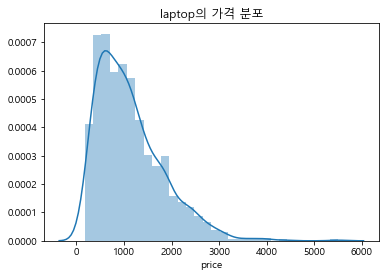

,count,mean,std,min,25%,50%,75%,max
price,1041.0,1128.795572,695.640814,174.0,589.52,985.0,1499.0,5499.0


In [22]:
# 시각화 한글 폰트 설정
plt.rc('font', family = 'Malgun Gothic')

# target 변수인 price의 분포 확인
sns.distplot(train_data['price'])
plt.title('laptop의 가격 분포')
plt.show()

# price의 기초 통계량
pd.DataFrame(train_data['price'].describe()).T

target 변수인 price는 왼쪽으로 치우친 분포  
평균이 약 5500인데 비해 평균이 약 1130
* 어떤 laptop이 높은 price를 갖는지 확인 필요

In [23]:
# 상대적으로 높은 가격(1500 이상)을 가지는 laptop만 filter
high_price_df = train_data[train_data['price'] >= 1500]

print(high_price_df.shape)
high_price_df.head()

(252, 22)


,Company,Product,TypeName,Inches,Ram,OpSys,resolution_pixel,IPS_panel,Touchscreen,cpu_mf,cpu_series,cpu_num,cpu_hz,Memory_1_capacity,Memory_1_storage,Memory_2_capacity,Memory_2_storage,gpu_mf,gpu_name,gpu_num,weight_n,price
4,Razer,Blade,Ultrabook,12.5,16GB,Windows 10,3840x2160,1,1,Intel,Core i7,7500.0,2.5,512GB,SSD,NaN,NaN,Intel,HD,620.0,1.29,1799.0
6,Google,Pixelbook,Ultrabook,12.3,8GB,Chrome OS,2400x1600,0,1,Intel,Core i5,NaN,1.2,256GB,SSD,NaN,NaN,Intel,HD,615.0,1.10,1559.0
7,LG,Gram,Ultrabook,15.6,8GB,Windows 10,1920x1080,1,0,Intel,Core i7,8550.0,1.8,512GB,SSD,NaN,NaN,Intel,HD,620.0,1.09,2299.0
9,MSI,GE,Gaming,17.3,16GB,Windows 10,1920x1080,0,0,Intel,Core i7,7700.0,2.8,512GB,SSD,1TB,HDD,Nvidia,GeForce,1070.0,2.90,2415.0
10,Asus,ROG,Gaming,17.3,64GB,Windows 10,1920x1080,1,0,Intel,Core i7,6820.0,2.7,1TB,SSD,NaN,NaN,Nvidia,GeForce,980.0,3.58,3975.0


In [24]:
# 상대적으로 낮은 가격(1500 이하)을 가지는 laptop만 filter
low_price_df = train_data[train_data['price'] < 1500]

print(low_price_df.shape)
low_price_df.head()

(789, 22)


,Company,Product,TypeName,Inches,Ram,OpSys,resolution_pixel,IPS_panel,Touchscreen,cpu_mf,cpu_series,cpu_num,cpu_hz,Memory_1_capacity,Memory_1_storage,Memory_2_capacity,Memory_2_storage,gpu_mf,gpu_name,gpu_num,weight_n,price
0,HP,250,Notebook,15.6,4GB,No OS,1366x768,0,0,Intel,Core i5,7200.0,2.5,500GB,HDD,NaN,NaN,Intel,HD,620.0,1.86,393.90
1,Asus,X,Notebook,NaN,4GB,Windows 10,1920x1080,0,0,Intel,intel_other,3350.0,1.1,1TB,HDD,NaN,NaN,Intel,HD,500.0,2.00,344.00
2,HP,15,Notebook,15.6,6GB,Windows 10,1366x768,0,0,Intel,Core i7,6500.0,2.5,1TB,HDD,NaN,NaN,AMD,Radeon,330.0,2.19,764.00
3,Dell,Inspiron,Gaming,15.6,16GB,Windows 10,3840x2160,1,1,Intel,Core i7,6700.0,2.6,128GB,SSD,1TB,HDD,Nvidia,GeForce,960.0,2.72,1099.00
5,Dell,Latitude,Notebook,14.0,8GB,Windows 10,1920x1080,0,0,Intel,Core i5,7300.0,2.6,256GB,SSD,NaN,NaN,Intel,HD,620.0,1.64,1279.73


**가격을 기준으로 제조사에서 차이가 있는지 비교**

In [25]:
# 높은 가격과 낮은 가격의 제조사별 비율 비교
temp_1 = (pd.DataFrame(high_price_df['Company'].value_counts())/sum(high_price_df['Company'].value_counts())*100).apply(lambda x: round(x, 2)).reset_index()
temp_2 = (pd.DataFrame(low_price_df['Company'].value_counts())/sum(low_price_df['Company'].value_counts())*100).apply(lambda x: round(x, 2)).reset_index()
result = pd.merge(temp_1, temp_2, how='outer', on='index')
result_df = result.T.drop('index', axis=0)
result_df.index=['higher_price', 'lower_price']
result_df.columns=result['index']
result_df

index,Lenovo,Dell,HP,Asus,MSI,Toshiba,Apple,Razer,Samsung,LG,Microsoft,Acer,Google,Vero,Mediacom,Chuwi,Xiaomi,Fujitsu,Huawei
higher_price,23.41,22.62,18.65,11.51,9.52,3.97,2.78,1.98,1.98,1.19,0.79,0.79,0.79,NaN,NaN,NaN,NaN,NaN,NaN
lower_price,23.45,21.8,21.29,12.8,2.53,3.93,1.52,0.13,0.13,NaN,0.25,10.14,0.13,0.51,0.51,0.38,0.25,0.13,0.13


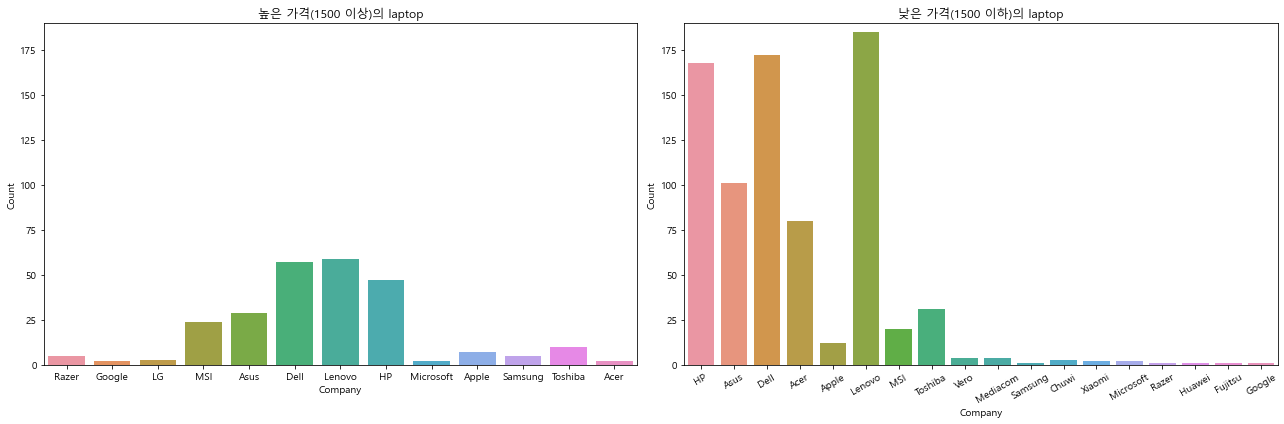

In [26]:
# 높은 가격과 낮은 가격의 시각적 비교
figure, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))
sns.countplot(high_price_df['Company'], ax=ax1)
sns.countplot(low_price_df['Company'], ax=ax2)
ax1.set(ylabel='Count',title="높은 가격(1500 이상)의 laptop", ylim=(0, 190))
ax2.set(ylabel='Count',title="낮은 가격(1500 이하)의 laptop", ylim=(0, 190))
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=30)
figure.tight_layout()
plt.show()

가격을 기준으로 구분하였을 때 분포의 상대적인 차이가 있는 것으로 보임
* 높은 가격의 laptop에서는 Acer가 차지하는 비율이 적은데 반면 낮은 가격에서는 Acer가 상당수 차지
* MSI는 높은 가격에서 많은 비율을 차지
* 낮은 가격에서는 Samsung, Razer, LG가 거의 없음
* 높은 가격에서는 Mediacom, Vero, Chuwi, Xiaomi, Huawei, Fujitsu가 없음

**가격을 기준으로 laptop분류(Typename)에 차이가 있는지 비교**

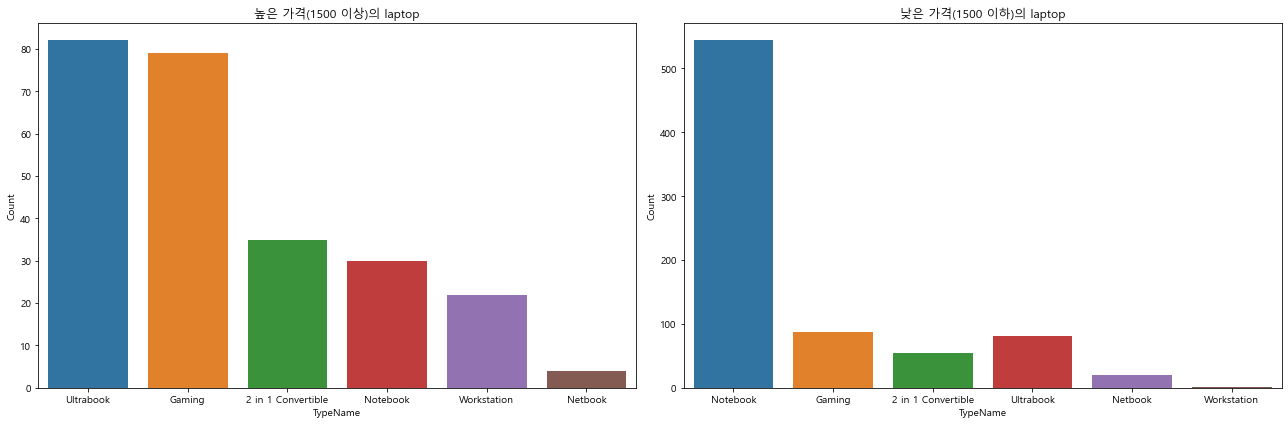

In [27]:
# 높은 가격과 낮은 가격의 시각적 비교
figure, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))
sns.countplot(high_price_df['TypeName'], ax=ax1)
sns.countplot(low_price_df['TypeName'], ax=ax2)
ax1.set(ylabel='Count',title="높은 가격(1500 이상)의 laptop")
ax2.set(ylabel='Count',title="낮은 가격(1500 이하)의 laptop")
# ax2.set_xticklabels(ax2.get_xticklabels(), rotation=30)
figure.tight_layout()
plt.show()

가격에 따라 laptop의 종류의 분포도 차이가 있음
* 높은 가격에서는 Ultrabook, Gaming이 높은 비율을 차지
* Workstation은 상대적으로 높은 가격에 많이 존재

**가격을 기준으로 화면크기(Inches)에 차이가 있는지 비교**

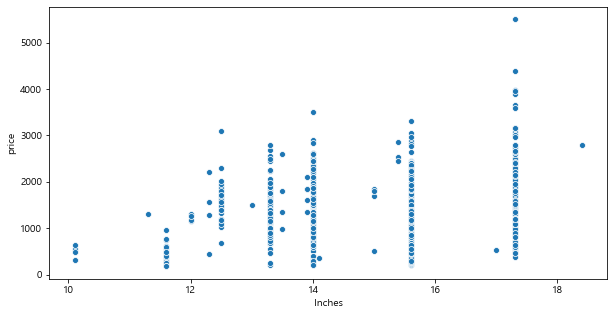

In [28]:
# 가격(price)와 무게(weight)와의 산점도 비교
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Inches', y='price', data=train_data)
plt.show()

화면크기와 가격 사이에 상관관계가 있는 것으로 보이고 큰 화면크기에서 높은 가격의 laptop이 존재  
하지만 화면크기에 따른 가격 분포가 넓은 것으로 보임

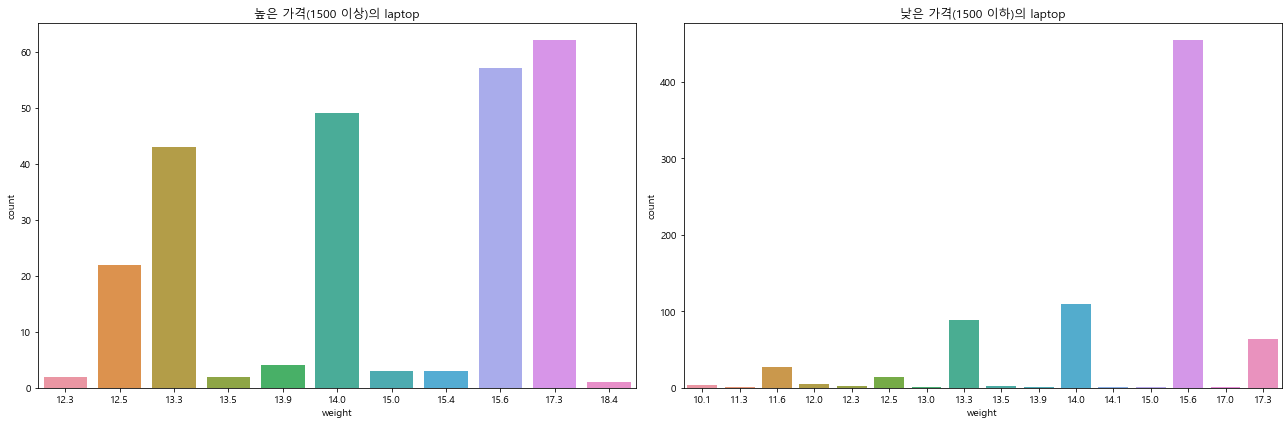

In [29]:
# Inches 컬럼이 결측치인 행은 제거
high_na_drop = high_price_df[~high_price_df['Inches'].isnull()]
low_na_drop = low_price_df[~low_price_df['Inches'].isnull()]

# 높은 가격과 낮은 가격의 시각적 비교
figure, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))
sns.countplot(high_na_drop['Inches'], ax=ax1)
sns.countplot(low_na_drop['Inches'], ax=ax2)
ax1.set(xlabel='weight', ylabel='count',title="높은 가격(1500 이상)의 laptop")
ax2.set(xlabel='weight', ylabel='count',title="낮은 가격(1500 이하)의 laptop")
figure.tight_layout()
plt.show()

높은 가격에 상대적으로 큰 화면크기의 laptop의 비율이 많은 것으로 보이나  
그렇다고 작은 크기의 laptop 비율이 작은 것은 아님

**가격을 기준으로 RAM, OS, 해상도에 차이가 있는지 비교**

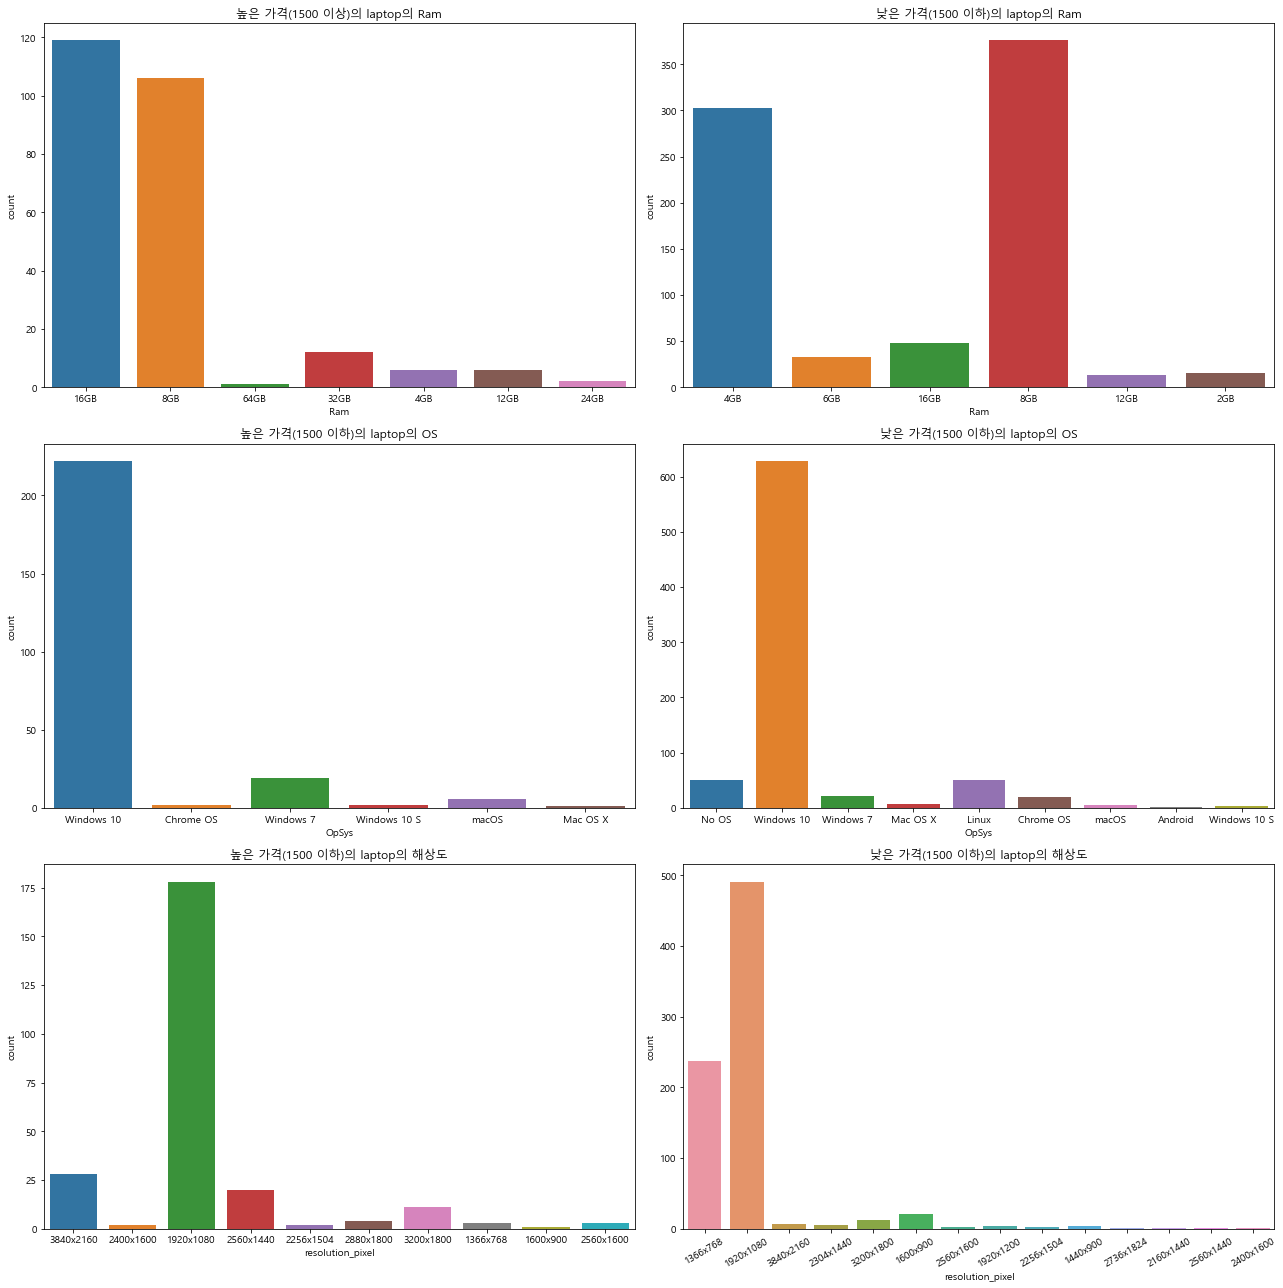

In [30]:
figure, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(18, 18))
sns.countplot(high_price_df['Ram'], ax=ax1); sns.countplot(low_price_df['Ram'], ax=ax2)
sns.countplot(high_price_df['OpSys'], ax=ax3); sns.countplot(low_price_df['OpSys'], ax=ax4)
sns.countplot(high_price_df['resolution_pixel'], ax=ax5); sns.countplot(low_price_df['resolution_pixel'], ax=ax6)
ax1.set(ylabel='count',title="높은 가격(1500 이상)의 laptop의 Ram"); ax2.set(ylabel='count',title="낮은 가격(1500 이하)의 laptop의 Ram")
ax3.set(ylabel='count',title="높은 가격(1500 이하)의 laptop의 OS"); ax4.set(ylabel='count',title="낮은 가격(1500 이하)의 laptop의 OS")
ax5.set(ylabel='count',title="높은 가격(1500 이하)의 laptop의 해상도"); ax6.set(ylabel='count',title="낮은 가격(1500 이하)의 laptop의 해상도")
ax6.set_xticklabels(ax6.get_xticklabels(), rotation=30)
figure.tight_layout()
plt.show()

-RAM  
높은 가격의 laptop에서 16GB의 RAM의 비율이 월등히 높음, 반대로 낮은 가격의 laptop에서는 4GB의 RAM의 비율이 높음  
낮은 가격의 laptop에서는 24, 32, 64GB의 RAM이 없음, 높은 가격에서는 6GB의 RAM이 없음

-OS  
낮은 가격 laptop에서는 OS가 없고 대신 높은 가격의 laptop에서 없는 Linux가 다소 있음

-해상도  
낮은 가격의 laptop에서는 1366x768이 상대적으로 많음  
높은 가격의 laptop에서는 2840x2160의 비율이 상대적으로 많음  

**가격을 기준으로 CPU에 차이가 있는지 비교**

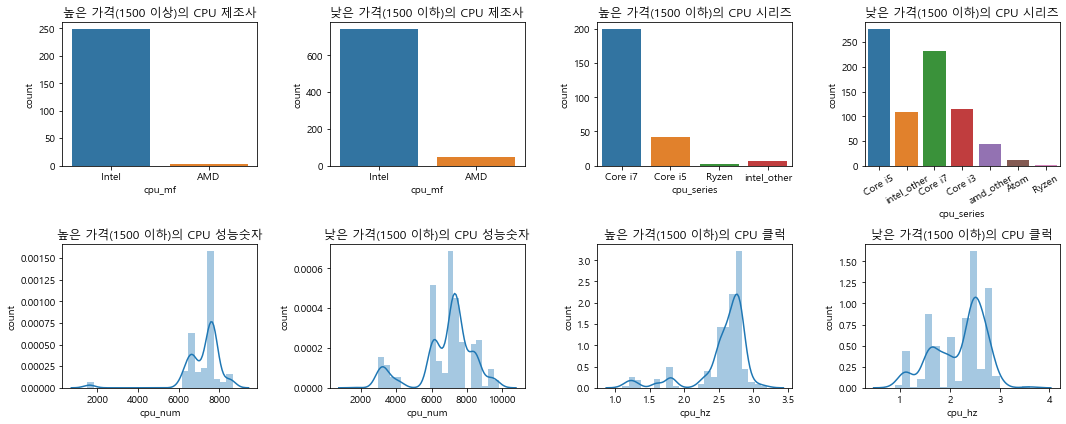

In [31]:
figure, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(nrows=2, ncols=4, figsize=(15, 6))
sns.countplot(high_price_df['cpu_mf'], ax=ax1); sns.countplot(low_price_df['cpu_mf'], ax=ax2)
sns.countplot(high_price_df['cpu_series'], ax=ax3); sns.countplot(low_price_df['cpu_series'], ax=ax4)
sns.distplot(high_price_df['cpu_num'], ax=ax5); sns.distplot(low_price_df['cpu_num'], ax=ax6)
sns.distplot(high_price_df['cpu_hz'], ax=ax7); sns.distplot(low_price_df['cpu_hz'], ax=ax8)
ax1.set(ylabel='count',title="높은 가격(1500 이상)의 CPU 제조사"); ax2.set(ylabel='count',title="낮은 가격(1500 이하)의 CPU 제조사")
ax3.set(ylabel='count',title="높은 가격(1500 이하)의 CPU 시리즈"); ax4.set(ylabel='count',title="낮은 가격(1500 이하)의 CPU 시리즈")
ax5.set(ylabel='count',title="높은 가격(1500 이하)의 CPU 성능숫자"); ax6.set(ylabel='count',title="낮은 가격(1500 이하)의 CPU 성능숫자")
ax7.set(ylabel='count',title="높은 가격(1500 이하)의 CPU 클럭"); ax8.set(ylabel='count',title="낮은 가격(1500 이하)의 CPU 클럭")
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=30)
figure.tight_layout()
plt.show()

낮은 가격의 laptop에서 AMD의 비율이 상대적으로 높지만 큰 차이는 아님  
낮은 가격의 laptop은 other CPU의 비율이 높고, 높은 가격의 laptop에는 Core i3 시리즈가 없음, 'other'에 속하는 것들이 많음  
낮은 가격의 laptop의 CPU 성능숫자의 분포가 더 넓음  
클럭은 낮은 클럭이 낮은 가격의 laptop에서 비율이 더 높지만 높은 클럭에서는 큰 차이를 보이지는 않음

**가격을 기준으로 IPS panel, Touchscreen에 차이가 있는지 비교**

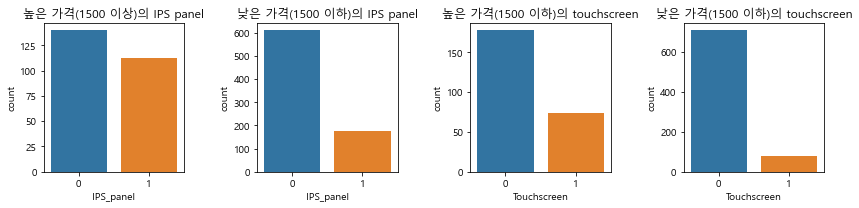

In [32]:
figure, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))
sns.countplot(high_price_df['IPS_panel'], ax=ax1); sns.countplot(low_price_df['IPS_panel'], ax=ax2)
sns.countplot(high_price_df['Touchscreen'], ax=ax3); sns.countplot(low_price_df['Touchscreen'], ax=ax4)
ax1.set(ylabel='count',title="높은 가격(1500 이상)의 IPS panel"); ax2.set(ylabel='count',title="낮은 가격(1500 이하)의 IPS panel")
ax3.set(ylabel='count',title="높은 가격(1500 이하)의 touchscreen"); ax4.set(ylabel='count',title="낮은 가격(1500 이하)의 touchscreen")
figure.tight_layout()
plt.show()

높은 가격에서 IPS panel과 touchscreen의 비율이 더 높음

**가격을 기준으로 Memory에 차이가 있는지 비교**

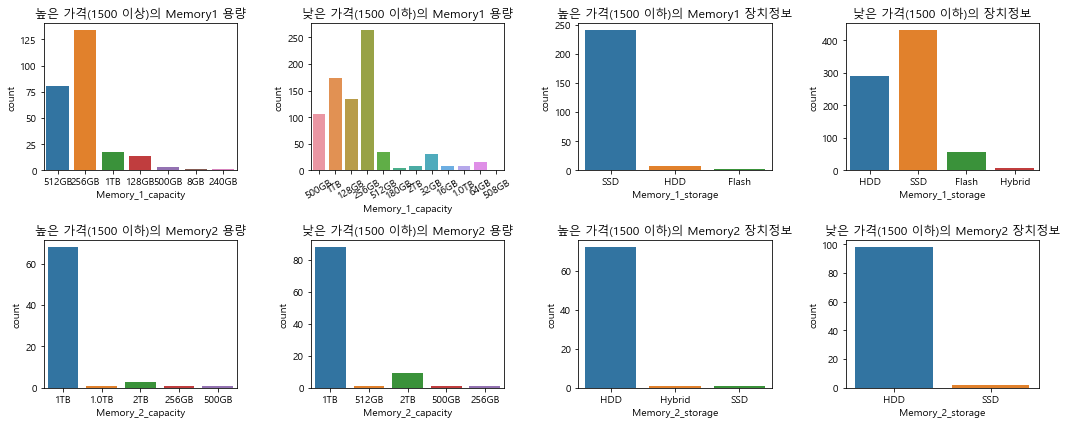

In [33]:
figure, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(nrows=2, ncols=4, figsize=(15, 6))
sns.countplot(high_price_df['Memory_1_capacity'], ax=ax1); sns.countplot(low_price_df['Memory_1_capacity'], ax=ax2)
sns.countplot(high_price_df['Memory_1_storage'], ax=ax3); sns.countplot(low_price_df['Memory_1_storage'], ax=ax4)
sns.countplot(high_price_df['Memory_2_capacity'], ax=ax5); sns.countplot(low_price_df['Memory_2_capacity'], ax=ax6)
sns.countplot(high_price_df['Memory_2_storage'], ax=ax7); sns.countplot(low_price_df['Memory_2_storage'], ax=ax8)
ax1.set(ylabel='count',title="높은 가격(1500 이상)의 Memory1 용량"); ax2.set(ylabel='count',title="낮은 가격(1500 이하)의 Memory1 용량")
ax3.set(ylabel='count',title="높은 가격(1500 이하)의 Memory1 장치정보"); ax4.set(ylabel='count',title="낮은 가격(1500 이하)의 장치정보")
ax5.set(ylabel='count',title="높은 가격(1500 이하)의 Memory2 용량"); ax6.set(ylabel='count',title="낮은 가격(1500 이하)의 Memory2 용량")
ax7.set(ylabel='count',title="높은 가격(1500 이하)의 Memory2 장치정보"); ax8.set(ylabel='count',title="낮은 가격(1500 이하)의 Memory2 장치정보")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=30)
figure.tight_layout()
plt.show()

Memory1에서 낮은 가격의 laptop은 분포가 넓음, 1TB, 128GB의 비율이 더 높음    
Memory2에서는 큰 차이가 없음  
낮은 가격에서 HDD의 비율이 더 높음  

## 3. 모델링을 위한 데이터 전처리

### 3-1 변수 변환
#### 먼저 앞서 진행한 탐색적 분석을 위한 전처리와 유사한 작업 진행

In [148]:
train_df = train.copy()
train_df.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,price
0,HP,250 G6,Notebook,15.6,1366x768,Intel Core i5 7200U 2.5GHz,4GB,500GB HDD,Intel HD Graphics 620,No OS,1.86kg,393.9
1,Asus,X541NA (N3350/4GB/1TB/FHD/W10),Notebook,NaN,Full HD 1920x1080,Intel Celeron Dual Core N3350 1.1GHz,4GB,1TB HDD,Intel HD Graphics 500,Windows 10,2kg,344.0
2,HP,15-AC110nv (i7-6500U/6GB/1TB/Radeon,Notebook,15.6,1366x768,Intel Core i7 6500U 2.5GHz,6GB,1TB HDD,AMD Radeon R5 M330,Windows 10,2.19kg,764.0
3,Dell,Inspiron 7559,Gaming,15.6,IPS Panel Touchscreen / 4K Ultra HD 3840x2160,Intel Core i7 6700HQ 2.6GHz,16GB,128GB SSD + 1TB HDD,Nvidia GeForce GTX 960M,Windows 10,2.72kg,1099.0
4,Razer,Blade Stealth,Ultrabook,12.5,IPS Panel 4K Ultra HD / Touchscreen 3840x2160,Intel Core i7 7500U 2.5GHz,16GB,512GB SSD,Intel HD Graphics 620,Windows 10,1.29kg,1799.0


In [149]:
# Product 컬럼 제품명 추출
train_df['Product'] = train_df['Product'].str.lower()
train_df['Product'] = train_df['Product'].str.split(' ').str[0]
train_df['Product'] = train_df['Product'].str.split('-').str[0]

temp_list = []
for n in range(len(train_df)):
    if train_df.iloc[n]['Company'] in ['Asus', 'MSI', 'Lenovo', 'Acer', 'Mediacom', 'Vero'] and train_df.iloc[n]['Company'] != 'HP':
        product = train_df.iloc[n]['Product']
        num = re.findall('\d', product)
        if num != []:
            num = re.findall('\d', product)[0]
            result = product.split(num)[0]
        else:
            result = train_df.iloc[n]['Product']
    else:
        result = train_df.iloc[n]['Product']
    temp_list.append(result)
    
train_df['Product'] = pd.Series(temp_list)

# ScreenResolution 변수 전처리
train_df['ScreenResolution'] = train_df['ScreenResolution'].str.lower()
train_df['resolution_pixel'] = train_df['ScreenResolution'].str.split(' ').str[-1]
train_df['IPS_panel'] = train_df['ScreenResolution'].str.contains('ips panel').astype('int')
train_df['Touchscreen'] = train_df['ScreenResolution'].str.contains('touchscreen').astype('int')

# CPU 변수 전처리
train_df['cpu_mf'] = train_df['Cpu'].str.split(' ').str[0]
train_df['cpu_series'] = train_df['Cpu'].apply(get_series)
train_df['cpu_num'] = train_df['Cpu'].str.extract(r'(\d{4})')
train_df['cpu_hz'] = train_df['Cpu'].str.split(' ').str[-1]
train_df['cpu_hz'] = train_df['cpu_hz'].str.split('GHz').str[0]
train_df['cpu_hz'] = train_df['cpu_hz'].astype('float')
train_df.drop(train_data[train_data['cpu_mf'] == 'Samsung'].index, axis=0, inplace=True)
train_df.drop(train_df[train_df['cpu_series'] == 'Ryzen'].index, axis=0, inplace=True)

# Memory 변수 전처리
train_df['Memory_1'] = train_df['Memory'].str.split('+').str[0]
train_df['Memory_2'] = train_df['Memory'].str.split('+').str[1].str.strip()
train_df['Memory_1_capacity'] = train_df['Memory_1'].str.split(' ').str[0]
train_df['Memory_1_storage'] = train_df['Memory_1'].str.split(' ').str[1]
train_df['Memory_2_capacity'] = train_df['Memory_2'].str.split(' ').str[0]
train_df['Memory_2_storage'] = train_df['Memory_2'].str.split(' ').str[1]

# GPU 변수 전처리
train_df['gpu_mf'] = train_df['Gpu'].str.split(' ').str[0]
train_df['gpu_name'] = train_df['Gpu'].str.split(' ').str[1]
train_df['gpu_num'] = train_df['Gpu'].str.extract(r'(\d{3,4})')
train_df.drop(train_df[train_df['gpu_name'] == 'Graphics'].index, axis=0, inplace=True)
train_df.drop(train_df[train_df['gpu_name'] == 'GTX'].index, axis=0, inplace=True)

# Weight 변수 전처리
train_df['weight_n'] = train_df['Weight'].str.split('kg').str[0].astype('float')

# ScreenResolution, Cpu, Memory, Memory_1, 2, Gpu, Weight 컬럼 drop
train_df = train_df.drop(['ScreenResolution', 'Cpu', 'Memory', 'Memory_1', 'Memory_2', 'Gpu', 'Weight'], axis=1)

# 데이터 타입 변환
train_df['cpu_num'] = train_df['cpu_num'].astype('float'); train_df['gpu_num'] = train_df['gpu_num'].astype('float')

# 제조사 samsung 인 열 drop
train_df.drop(train_df[train_df['cpu_mf'] == 'Samsung'].index, axis=0, inplace=True)
train_df.drop(train_df[train_df['Company'] == 'LG'].index, axis=0, inplace=True)

#OpSys
train_df['OpSys'] = train_df['OpSys'].str.replace('Mac OS X', 'macOS')
train_df.drop(train_df[train_df['OpSys'] == 'Android'].index, axis=0, inplace=True)

train_df.head()

,Company,Product,TypeName,Inches,Ram,OpSys,price,resolution_pixel,IPS_panel,Touchscreen,cpu_mf,cpu_series,cpu_num,cpu_hz,Memory_1_capacity,Memory_1_storage,Memory_2_capacity,Memory_2_storage,gpu_mf,gpu_name,gpu_num,weight_n
0,HP,250,Notebook,15.6,4GB,No OS,393.9,1366x768,0,0,Intel,Core i5,7200.0,2.5,500GB,HDD,NaN,NaN,Intel,HD,620.0,1.86
1,Asus,x,Notebook,NaN,4GB,Windows 10,344.0,1920x1080,0,0,Intel,intel_other,3350.0,1.1,1TB,HDD,NaN,NaN,Intel,HD,500.0,2.00
2,HP,15,Notebook,15.6,6GB,Windows 10,764.0,1366x768,0,0,Intel,Core i7,6500.0,2.5,1TB,HDD,NaN,NaN,AMD,Radeon,330.0,2.19
3,Dell,inspiron,Gaming,15.6,16GB,Windows 10,1099.0,3840x2160,1,1,Intel,Core i7,6700.0,2.6,128GB,SSD,1TB,HDD,Nvidia,GeForce,960.0,2.72
4,Razer,blade,Ultrabook,12.5,16GB,Windows 10,1799.0,3840x2160,1,1,Intel,Core i7,7500.0,2.5,512GB,SSD,NaN,NaN,Intel,HD,620.0,1.29


resolution_pixel 컬럼은 그대로 category 변수로 사용하지 않고 숫자 추출

In [150]:
# resolution_pixel 컬럼의 숫자 추출
train_df['res_1'] = train_df['resolution_pixel'].str.split('x').str[0]
train_df['res_2'] = train_df['resolution_pixel'].str.split('x').str[1]
train_df['res_1'] = train_df['res_1'].astype('int'); train_df['res_2'] = train_df['res_2'].astype('int') # data type 변경

memory의 용량인 Memory_1_capacity, Memory_2_capacity도 숫자만 추출하여 두 수의 합인 새로운 컬럼 생성

In [151]:
# 먼저 Memory_2의 capacity, storage 변수의 결측치는 'none'으로 처리
train_df['Memory_2_capacity'].fillna('none', inplace=True) 
train_df['Memory_2_storage'].fillna('none', inplace=True)

In [152]:
# 숫자 추출하기 위한 함수 정의
def memory_trans(memory):
    if 'TB' in memory:
        temp = float(memory.split('TB')[0])
        temp = int(temp)
        temp = temp * 1000
    elif 'GB' in memory:
        temp = int(memory.split('GB')[0])
    else:
        temp = 0 # memory_2_capacity의 'none'은 0으로 변환
    return temp

In [153]:
train_df['Memory_1_num'] = train_df['Memory_1_capacity'].apply(memory_trans)
train_df['Memory_2_num'] = train_df['Memory_2_capacity'].apply(memory_trans)
train_df['Memory_sum'] = train_df['Memory_1_num'] + train_df['Memory_2_num']

Ram 변수도 숫자로 변경

In [154]:
# 숫자만 추출
train_df['Ram_n'] = train_df['Ram'].str.split('GB').str[0]

# 데이터 type 변경
train_df['Ram_n'] = train_df['Ram_n'].astype('int')

TypeName 변수는 비슷한 분포를 보이는 'Notebook', 'Ultrabook', '2 in 1 Convertible' 을 하나로 합침

In [155]:
train_df['TypeName'].value_counts()

Notebook              574
Gaming                161
Ultrabook             159
2 in 1 Convertible     88
Workstation            24
Netbook                24
Name: TypeName, dtype: int64

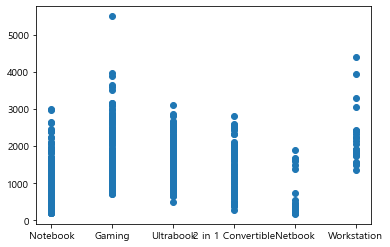

In [156]:
plt.scatter(train_df['TypeName'], train_df['price'])
plt.show()

In [157]:
train_df['TypeName'] = train_df['TypeName'].apply(lambda x: 'uni' if x in ['Notebook', 'Ultrabook', '2 in 1 Convertible'] else x)

Company 변수의 category 줄여주기 위해 다음과 같은 작업 수행

In [158]:
from sklearn.cluster import KMeans

temp_df = train_df[['Company', 'price']]
temp_df = pd.get_dummies(temp_df)

cluster = KMeans(n_clusters=5)
cluster.fit(temp_df)
pred = cluster.labels_

train_df['com_emb'] = pred
train_df.head()

,Company,Product,TypeName,Inches,Ram,OpSys,price,resolution_pixel,IPS_panel,Touchscreen,cpu_mf,cpu_series,cpu_num,cpu_hz,Memory_1_capacity,Memory_1_storage,Memory_2_capacity,Memory_2_storage,gpu_mf,gpu_name,gpu_num,weight_n,res_1,res_2,Memory_1_num,Memory_2_num,Memory_sum,Ram_n,com_emb
0,HP,250,uni,15.6,4GB,No OS,393.9,1366x768,0,0,Intel,Core i5,7200.0,2.5,500GB,HDD,none,none,Intel,HD,620.0,1.86,1366,768,500,0,500,4,2
1,Asus,x,uni,NaN,4GB,Windows 10,344.0,1920x1080,0,0,Intel,intel_other,3350.0,1.1,1TB,HDD,none,none,Intel,HD,500.0,2.00,1920,1080,1000,0,1000,4,2
2,HP,15,uni,15.6,6GB,Windows 10,764.0,1366x768,0,0,Intel,Core i7,6500.0,2.5,1TB,HDD,none,none,AMD,Radeon,330.0,2.19,1366,768,1000,0,1000,6,2
3,Dell,inspiron,Gaming,15.6,16GB,Windows 10,1099.0,3840x2160,1,1,Intel,Core i7,6700.0,2.6,128GB,SSD,1TB,HDD,Nvidia,GeForce,960.0,2.72,3840,2160,128,1000,1128,16,1
4,Razer,blade,uni,12.5,16GB,Windows 10,1799.0,3840x2160,1,1,Intel,Core i7,7500.0,2.5,512GB,SSD,none,none,Intel,HD,620.0,1.29,3840,2160,512,0,512,16,3


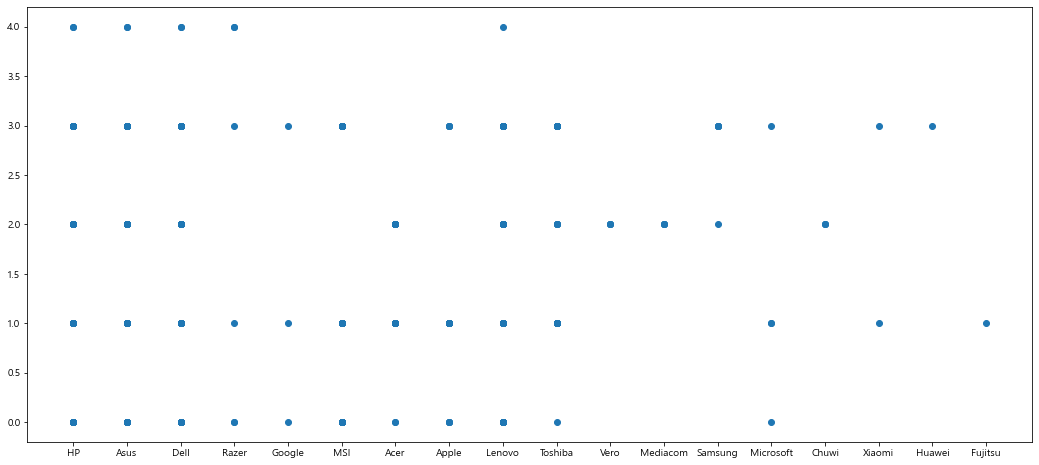

In [159]:
plt.figure(figsize=(18, 8))
plt.scatter(train_df['Company'], train_df['com_emb'])

산점도가 유사한 제조사는 묶어 줌

In [160]:
def company_embeding(company):
    if company in ['HP', 'Asus', 'Dell', 'Lenovo']:
        result = 'hadl'
    elif company in ['Razer', 'MSI', 'Apple']:
        result = 'rma'
    elif company in ['Google', 'Microsoft']:
        result = 'gm'
    elif company in ['Vero', 'Mediacom', 'Chuwi']:
        result = 'vmc'
    elif company in ['Xiaomi', 'Huawei', 'Fujitsu']:
        result = 'xhf'
    else:
        result = company
    return result

In [161]:
train_df['Company'] = train_df['Company'].apply(company_embeding)
train_df.head()

,Company,Product,TypeName,Inches,Ram,OpSys,price,resolution_pixel,IPS_panel,Touchscreen,cpu_mf,cpu_series,cpu_num,cpu_hz,Memory_1_capacity,Memory_1_storage,Memory_2_capacity,Memory_2_storage,gpu_mf,gpu_name,gpu_num,weight_n,res_1,res_2,Memory_1_num,Memory_2_num,Memory_sum,Ram_n,com_emb
0,hadl,250,uni,15.6,4GB,No OS,393.9,1366x768,0,0,Intel,Core i5,7200.0,2.5,500GB,HDD,none,none,Intel,HD,620.0,1.86,1366,768,500,0,500,4,2
1,hadl,x,uni,NaN,4GB,Windows 10,344.0,1920x1080,0,0,Intel,intel_other,3350.0,1.1,1TB,HDD,none,none,Intel,HD,500.0,2.00,1920,1080,1000,0,1000,4,2
2,hadl,15,uni,15.6,6GB,Windows 10,764.0,1366x768,0,0,Intel,Core i7,6500.0,2.5,1TB,HDD,none,none,AMD,Radeon,330.0,2.19,1366,768,1000,0,1000,6,2
3,hadl,inspiron,Gaming,15.6,16GB,Windows 10,1099.0,3840x2160,1,1,Intel,Core i7,6700.0,2.6,128GB,SSD,1TB,HDD,Nvidia,GeForce,960.0,2.72,3840,2160,128,1000,1128,16,1
4,rma,blade,uni,12.5,16GB,Windows 10,1799.0,3840x2160,1,1,Intel,Core i7,7500.0,2.5,512GB,SSD,none,none,Intel,HD,620.0,1.29,3840,2160,512,0,512,16,3


가격에 가장 큰 영향을 미치는 것은 product 일 것이라 예상되므로  
product를 price에 따라 clusturing한 변수 사용

In [162]:
from sklearn.cluster import KMeans

temp_df = train_df[['price']]
temp = temp_df.values.reshape(-1, 1)

cluster_coun = 10
cluster = KMeans(n_clusters=cluster_coun)
cluster.fit(temp)
pred = cluster.labels_

train_df["cluster"] = pred
train_df.head()

,Company,Product,TypeName,Inches,Ram,OpSys,price,resolution_pixel,IPS_panel,Touchscreen,cpu_mf,cpu_series,cpu_num,cpu_hz,Memory_1_capacity,Memory_1_storage,Memory_2_capacity,Memory_2_storage,gpu_mf,gpu_name,gpu_num,weight_n,res_1,res_2,Memory_1_num,Memory_2_num,Memory_sum,Ram_n,com_emb,cluster
0,hadl,250,uni,15.6,4GB,No OS,393.9,1366x768,0,0,Intel,Core i5,7200.0,2.5,500GB,HDD,none,none,Intel,HD,620.0,1.86,1366,768,500,0,500,4,2,2
1,hadl,x,uni,NaN,4GB,Windows 10,344.0,1920x1080,0,0,Intel,intel_other,3350.0,1.1,1TB,HDD,none,none,Intel,HD,500.0,2.00,1920,1080,1000,0,1000,4,2,2
2,hadl,15,uni,15.6,6GB,Windows 10,764.0,1366x768,0,0,Intel,Core i7,6500.0,2.5,1TB,HDD,none,none,AMD,Radeon,330.0,2.19,1366,768,1000,0,1000,6,2,4
3,hadl,inspiron,Gaming,15.6,16GB,Windows 10,1099.0,3840x2160,1,1,Intel,Core i7,6700.0,2.6,128GB,SSD,1TB,HDD,Nvidia,GeForce,960.0,2.72,3840,2160,128,1000,1128,16,1,0
4,rma,blade,uni,12.5,16GB,Windows 10,1799.0,3840x2160,1,1,Intel,Core i7,7500.0,2.5,512GB,SSD,none,none,Intel,HD,620.0,1.29,3840,2160,512,0,512,16,3,5


In [163]:
for n in range(cluster_coun):
    exec("clus_" + str(n) + " = list(train_df[train_df['cluster'] == n]['Product'].unique())")

cluster_df = train_df.copy()
    
def product_embedding(product):
    max_num = 0
    max_idx = -1
    for i in range(cluster_coun):     
        if product in eval('clus_' + str(i)):
            num = cluster_df[cluster_df['cluster'] == i]['Product'].value_counts()[product]
            if max_num <= num:
                max_num = num
                max_idx = i
        
        else:
            if max_idx == -1:
                max_idx = 21
    
    return max_idx

In [164]:
train_df['product_emb'] = train_df['Product'].apply(product_embedding)
train_df.head()

,Company,Product,TypeName,Inches,Ram,OpSys,price,resolution_pixel,IPS_panel,Touchscreen,cpu_mf,cpu_series,cpu_num,cpu_hz,Memory_1_capacity,Memory_1_storage,Memory_2_capacity,Memory_2_storage,gpu_mf,gpu_name,gpu_num,weight_n,res_1,res_2,Memory_1_num,Memory_2_num,Memory_sum,Ram_n,com_emb,cluster,product_emb
0,hadl,250,uni,15.6,4GB,No OS,393.9,1366x768,0,0,Intel,Core i5,7200.0,2.5,500GB,HDD,none,none,Intel,HD,620.0,1.86,1366,768,500,0,500,4,2,2,2
1,hadl,x,uni,NaN,4GB,Windows 10,344.0,1920x1080,0,0,Intel,intel_other,3350.0,1.1,1TB,HDD,none,none,Intel,HD,500.0,2.00,1920,1080,1000,0,1000,4,2,2,2
2,hadl,15,uni,15.6,6GB,Windows 10,764.0,1366x768,0,0,Intel,Core i7,6500.0,2.5,1TB,HDD,none,none,AMD,Radeon,330.0,2.19,1366,768,1000,0,1000,6,2,4,4
3,hadl,inspiron,Gaming,15.6,16GB,Windows 10,1099.0,3840x2160,1,1,Intel,Core i7,6700.0,2.6,128GB,SSD,1TB,HDD,Nvidia,GeForce,960.0,2.72,3840,2160,128,1000,1128,16,1,0,9
4,rma,blade,uni,12.5,16GB,Windows 10,1799.0,3840x2160,1,1,Intel,Core i7,7500.0,2.5,512GB,SSD,none,none,Intel,HD,620.0,1.29,3840,2160,512,0,512,16,3,5,6


### 3-2 결측치 처리

In [165]:
# 결측치 확인
train_df.isnull().sum()

Company               0
Product               0
TypeName              0
Inches               17
Ram                   0
OpSys                 0
price                 0
resolution_pixel      0
IPS_panel             0
Touchscreen           0
cpu_mf                0
cpu_series            0
cpu_num              41
cpu_hz                0
Memory_1_capacity     0
Memory_1_storage      0
Memory_2_capacity     0
Memory_2_storage      0
gpu_mf                0
gpu_name              0
gpu_num              52
weight_n              0
res_1                 0
res_2                 0
Memory_1_num          0
Memory_2_num          0
Memory_sum            0
Ram_n                 0
com_emb               0
cluster               0
product_emb           0
dtype: int64

**cpu_num, gpu_num 변수 결측치 처리**

In [166]:
# 다른 변수와의 상관관계를 확인하기 위한 temp 데이터프레임 생성
temp_df = train_df.copy()
temp_df.dropna(inplace=True)

# 데이터 타입 변환
temp_df['cpu_num'] = temp_df['cpu_num'].astype('int'); temp_df['gpu_num'] = temp_df['gpu_num'].astype('int')

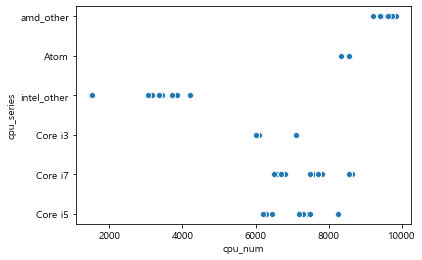

In [167]:
# cpu_num 변수와 cpu_series의 상관관계 확인
sns.scatterplot(x='cpu_num', y='cpu_series', data=temp_df)
plt.show()

cpu_series 별로 cpu_num의 분포 차이가 있어보이므로  
series 별 중간값으로 cpu_num 결측치 처리

In [168]:
# cpu의 series별 중간값으로 cpu_num 결측치 처리
train_df['cpu_num'] = train_df['cpu_num'].fillna(train_df.groupby('cpu_series')['cpu_num'].transform('median'))

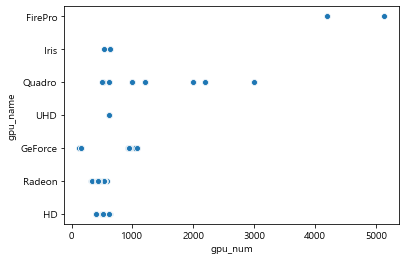

In [169]:
# gpu_num 변수와 gpu_name 상관관계 확인
sns.scatterplot(x='gpu_num', y='gpu_name', data=temp_df)
plt.show()

gpu_num도 name별로 분포의 차이를 보이므로  
gpu_name별로 gpu_num 결측치 처리

In [170]:
# gpu의 name별 중간값으로 cpu_num 결측치 처리
train_df['gpu_num'] = train_df['gpu_num'].fillna(train_df.groupby('gpu_name')['gpu_num'].transform('median'))

In [171]:
# gpu_num의 결측치 수 확인
print(train_df['gpu_num'].isnull().sum())

# gpu_name이 하나여서 gpu_num의 결측치가 채워지지 않은 행 drop
train_df.drop(train_df[train_df['gpu_num'].isnull()].index, axis=0, inplace=True)

2


**Inches 변수 결측치 처리**

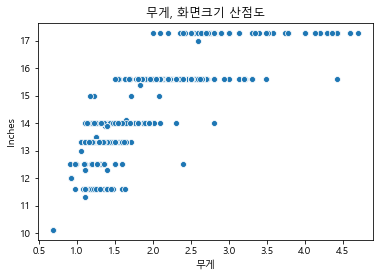

In [172]:
sns.scatterplot(x='weight_n', y='Inches', data=train_df)
plt.xlabel('무게')
plt.title('무게, 화면크기 산점도')
plt.show()

Inches 변수 결측치는 무게가 같은 laptop의 Inches의 최빈값으로 대체 

In [173]:
# 무게가 2.16인 행은 Inches가 모두 결측치이므로 drop
train_df.drop(train_df[train_df['weight_n'] == 2.16].index, axis=0, inplace=True)

# weight_n 별 Inches 결측치 처리
train_df['Inches'] = train_df.groupby(['weight_n'])['Inches'].apply(lambda x: x.fillna(x.mode()[0]))

In [174]:
# 결측치 확인
train_df.isnull().sum()

Company              0
Product              0
TypeName             0
Inches               0
Ram                  0
OpSys                0
price                0
resolution_pixel     0
IPS_panel            0
Touchscreen          0
cpu_mf               0
cpu_series           0
cpu_num              0
cpu_hz               0
Memory_1_capacity    0
Memory_1_storage     0
Memory_2_capacity    0
Memory_2_storage     0
gpu_mf               0
gpu_name             0
gpu_num              0
weight_n             0
res_1                0
res_2                0
Memory_1_num         0
Memory_2_num         0
Memory_sum           0
Ram_n                0
com_emb              0
cluster              0
product_emb          0
dtype: int64

### 3-3 이상치 처리

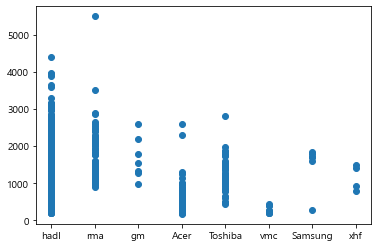

In [175]:
plt.scatter(train_df['Company'], train_df['price'])
plt.show()

price가 5000이 넘어가는 행 삭제

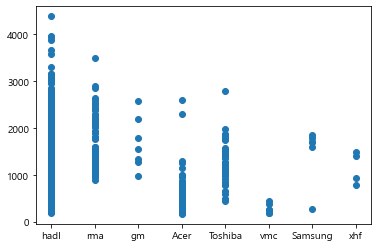

In [176]:
train_df.drop(train_df[train_df['price'] >= 5000].index, axis=0, inplace=True)

plt.scatter(train_df['Company'], train_df['price'])
plt.show()

### 3-4 레이블 인코딩

In [177]:
# # 인코딩 하기 위해 데이터 type 변환
# train_df['Ram_n'] = train_df['Ram_n'].astype(str)
# train_df['res_1'] = train_df['res_1'].astype(str)
# train_df['res_2'] = train_df['res_2'].astype(str)
# train_df['Memory_1_num'] = train_df['Memory_1_num'].astype(str)
# train_df['Memory_2_num'] = train_df['Memory_2_num'].astype(str)

In [178]:
# # 인코딩할 변수 정의
# cat_columns=['Ram_n', 'res_1', 'res_2', 'Memory_1_num', 'Memory_2_num', 'cpu_series']
# encoder = LabelEncoder()

# # category 변수 인코딩
# for cat in cat_columns:
#     encoder.fit(train_df[cat])
#     train_df[str(cat) + '_enc'] = encoder.transform(train_df[cat])
    
# train_df.head()

In [179]:
# # 필요없는 변수는 drop
# train_df.drop(['Ram', 'resolution_pixel', 'Memory_1_capacity', 'Memory_2_capacity', 'Memory_sum', 'cluster', 'com_emb', 'Product'], 
#                    axis=1, inplace=True)
# train_df.drop(cat_columns, axis=1, inplace=True)
train_df.head()

,Company,Product,TypeName,Inches,Ram,OpSys,price,resolution_pixel,IPS_panel,Touchscreen,cpu_mf,cpu_series,cpu_num,cpu_hz,Memory_1_capacity,Memory_1_storage,Memory_2_capacity,Memory_2_storage,gpu_mf,gpu_name,gpu_num,weight_n,res_1,res_2,Memory_1_num,Memory_2_num,Memory_sum,Ram_n,com_emb,cluster,product_emb
0,hadl,250,uni,15.6,4GB,No OS,393.9,1366x768,0,0,Intel,Core i5,7200.0,2.5,500GB,HDD,none,none,Intel,HD,620.0,1.86,1366,768,500,0,500,4,2,2,2
1,hadl,x,uni,15.6,4GB,Windows 10,344.0,1920x1080,0,0,Intel,intel_other,3350.0,1.1,1TB,HDD,none,none,Intel,HD,500.0,2.00,1920,1080,1000,0,1000,4,2,2,2
2,hadl,15,uni,15.6,6GB,Windows 10,764.0,1366x768,0,0,Intel,Core i7,6500.0,2.5,1TB,HDD,none,none,AMD,Radeon,330.0,2.19,1366,768,1000,0,1000,6,2,4,4
3,hadl,inspiron,Gaming,15.6,16GB,Windows 10,1099.0,3840x2160,1,1,Intel,Core i7,6700.0,2.6,128GB,SSD,1TB,HDD,Nvidia,GeForce,960.0,2.72,3840,2160,128,1000,1128,16,1,0,9
4,rma,blade,uni,12.5,16GB,Windows 10,1799.0,3840x2160,1,1,Intel,Core i7,7500.0,2.5,512GB,SSD,none,none,Intel,HD,620.0,1.29,3840,2160,512,0,512,16,3,5,6


In [180]:
train_df.drop(['Ram', 'resolution_pixel', 'Memory_1_capacity', 'Memory_2_capacity', 'cluster', 'com_emb', 'Product'], 
              axis=1, inplace=True)
train_df.head()

,Company,TypeName,Inches,OpSys,price,IPS_panel,Touchscreen,cpu_mf,cpu_series,cpu_num,cpu_hz,Memory_1_storage,Memory_2_storage,gpu_mf,gpu_name,gpu_num,weight_n,res_1,res_2,Memory_1_num,Memory_2_num,Memory_sum,Ram_n,product_emb
0,hadl,uni,15.6,No OS,393.9,0,0,Intel,Core i5,7200.0,2.5,HDD,none,Intel,HD,620.0,1.86,1366,768,500,0,500,4,2
1,hadl,uni,15.6,Windows 10,344.0,0,0,Intel,intel_other,3350.0,1.1,HDD,none,Intel,HD,500.0,2.00,1920,1080,1000,0,1000,4,2
2,hadl,uni,15.6,Windows 10,764.0,0,0,Intel,Core i7,6500.0,2.5,HDD,none,AMD,Radeon,330.0,2.19,1366,768,1000,0,1000,6,4
3,hadl,Gaming,15.6,Windows 10,1099.0,1,1,Intel,Core i7,6700.0,2.6,SSD,HDD,Nvidia,GeForce,960.0,2.72,3840,2160,128,1000,1128,16,9
4,rma,uni,12.5,Windows 10,1799.0,1,1,Intel,Core i7,7500.0,2.5,SSD,none,Intel,HD,620.0,1.29,3840,2160,512,0,512,16,6


### 3-5 One-hot Encoding

In [181]:
train_df['product_emb'] = train_df['product_emb'].astype('str')
train_df = pd.get_dummies(train_df)
print(train_df.shape)

# 최종 데이터
train_df.head()

(1025, 67)


,Inches,price,IPS_panel,Touchscreen,cpu_num,cpu_hz,gpu_num,weight_n,res_1,res_2,Memory_1_num,Memory_2_num,Memory_sum,Ram_n,Company_Acer,Company_Samsung,Company_Toshiba,Company_gm,Company_hadl,Company_rma,...,Memory_2_storage_SSD,Memory_2_storage_none,gpu_mf_AMD,gpu_mf_Intel,gpu_mf_Nvidia,gpu_name_FirePro,gpu_name_GeForce,gpu_name_HD,gpu_name_Iris,gpu_name_Quadro,gpu_name_Radeon,gpu_name_UHD,product_emb_0,product_emb_1,product_emb_2,product_emb_4,product_emb_5,product_emb_6,product_emb_7,product_emb_9
0,15.6,393.9,0,0,7200.0,2.5,620.0,1.86,1366,768,500,0,500,4,0,0,0,0,1,0,...,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
1,15.6,344.0,0,0,3350.0,1.1,500.0,2.00,1920,1080,1000,0,1000,4,0,0,0,0,1,0,...,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2,15.6,764.0,0,0,6500.0,2.5,330.0,2.19,1366,768,1000,0,1000,6,0,0,0,0,1,0,...,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
3,15.6,1099.0,1,1,6700.0,2.6,960.0,2.72,3840,2160,128,1000,1128,16,0,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,12.5,1799.0,1,1,7500.0,2.5,620.0,1.29,3840,2160,512,0,512,16,0,0,0,0,0,1,...,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [182]:
train_df.columns

Index(['Inches', 'price', 'IPS_panel', 'Touchscreen', 'cpu_num', 'cpu_hz',
       'gpu_num', 'weight_n', 'res_1', 'res_2', 'Memory_1_num', 'Memory_2_num',
       'Memory_sum', 'Ram_n', 'Company_Acer', 'Company_Samsung',
       'Company_Toshiba', 'Company_gm', 'Company_hadl', 'Company_rma',
       'Company_vmc', 'Company_xhf', 'TypeName_Gaming', 'TypeName_Netbook',
       'TypeName_Workstation', 'TypeName_uni', 'OpSys_Chrome OS',
       'OpSys_Linux', 'OpSys_No OS', 'OpSys_Windows 10', 'OpSys_Windows 10 S',
       'OpSys_Windows 7', 'OpSys_macOS', 'cpu_mf_AMD', 'cpu_mf_Intel',
       'cpu_series_Atom', 'cpu_series_Core i3', 'cpu_series_Core i5',
       'cpu_series_Core i7', 'cpu_series_amd_other', 'cpu_series_intel_other',
       'Memory_1_storage_Flash', 'Memory_1_storage_HDD',
       'Memory_1_storage_Hybrid', 'Memory_1_storage_SSD',
       'Memory_2_storage_HDD', 'Memory_2_storage_Hybrid',
       'Memory_2_storage_SSD', 'Memory_2_storage_none', 'gpu_mf_AMD',
       'gpu_mf_Intel', 'g

## 4. 모델 구축과 검증

### 4-1 변수 선택  
* boruta algorithm

오히려 성능이 저하되서 변수 그대로 사용

In [167]:
# from boruta import BorutaPy

# rf = RandomForestRegressor(n_jobs=-1, n_estimators=200, max_depth=5)

# feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)

# feat_selector.fit(X_train.values, y_train.values)

In [168]:
# feature_ranks = list(zip(X_train.columns, 
#                          feat_selector.ranking_, 
#                          feat_selector.support_))

# # iterate through and print out the results
# for feat in feature_ranks:
#     print('Feature: {:<25} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))

### 4-2모델 구축

In [183]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [184]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# 독립변수(X_features), 종속변수(y_target) 분리
X_features = train_df.drop('price', axis=1)
y_target = train_df['price']

# train set과 test set 생성
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2)

# train set과 test set의 shape
print('X_train:', X_train.shape,', X_test:', X_test.shape)
print('y_train:', y_train.shape,', y_test:', y_test.shape)

X_train: (820, 66) , X_test: (205, 66)
y_train: (820,) , y_test: (205,)


**RandomForestRegressor, Lightgbm, XGBoost 각각의 성능 비교**

In [187]:
from sklearn.model_selection import GridSearchCV

rf_reg = RandomForestRegressor()

param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [8, 10, 12, 14],
#     'learning_rate': [0.02, 0.05, 0.1],
#     'num_leaves': [26, 31, 36]
    'min_samples_split': [1, 2]
}


grid_search = GridSearchCV(rf_reg,
                        param_grid,
                        cv = 3,
                        n_jobs = -1,
                        verbose=True)

grid_search.fit(X_features, y_target)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   50.5s finished


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [8, 10, 12, 14],
                         'min_samples_split': [1, 2],
                         'n_estimators': [300, 400, 500]},
             verbose=True)

In [188]:
grid_search.best_params_

{'max_depth': 12, 'min_samples_split': 2, 'n_estimators': 300}

In [186]:
np.sqrt(72424)

269.11707489492375

In [185]:
# RandomForestRegressor의 성능 확인
rf_reg = RandomForestRegressor(n_estimators=400, max_depth=12, max_features='sqrt', min_samples_split=2)
mse_scores = cross_val_score(rf_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=3)

print(np.round(mse_scores, 5))
print(mse_scores.mean())

[-84123.39609 -68996.20026 -64154.63246]
-72424.74293410554


In [189]:
# Lightgbm regressor의 성능 확인
lgbm_reg = LGBMRegressor(n_estimators=400, max_depth=8, num_leaves=26 ,learning_rate=0.05)
mse_scores = cross_val_score(lgbm_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=3)

print(np.round(mse_scores, 5))
print(mse_scores.mean())

[-83272.44828 -67452.7417  -67216.84313]
-72647.34436878757


In [190]:
# XGBoost regressor의 성능 확인
xgb_reg = XGBRegressor(n_estimators=500, learning_rate=0.05)
mse_scores = cross_val_score(xgb_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=3)

print(np.round(mse_scores, 5))
print(mse_scores.mean())

[-80998.78477 -67786.18252 -59936.34467]
-69573.77065645666


**stacking 모델 적용**

In [191]:
# estimators 정의
estimators = [
    ('rf_reg', RandomForestRegressor(n_estimators=400, max_features='sqrt', min_samples_split=2)),
    ('lgbm_reg', LGBMRegressor(n_estimators=400, learning_rate=0.05)),
    ('xgb_reg', XGBRegressor(n_estimators=500, learning_rate=0.05))
]

# 최종 estimators는 RandomForest regressor
st_reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=100))

# MSE cross validation
mse_scores = cross_val_score(st_reg, X_train.values, y_train.values, scoring='neg_mean_squared_error', cv=3, error_score='raise')

print(np.round(mse_scores, 5))
print(mse_scores.mean())

[-90444.42463 -74510.52334 -63879.80805]
-76278.25200331648


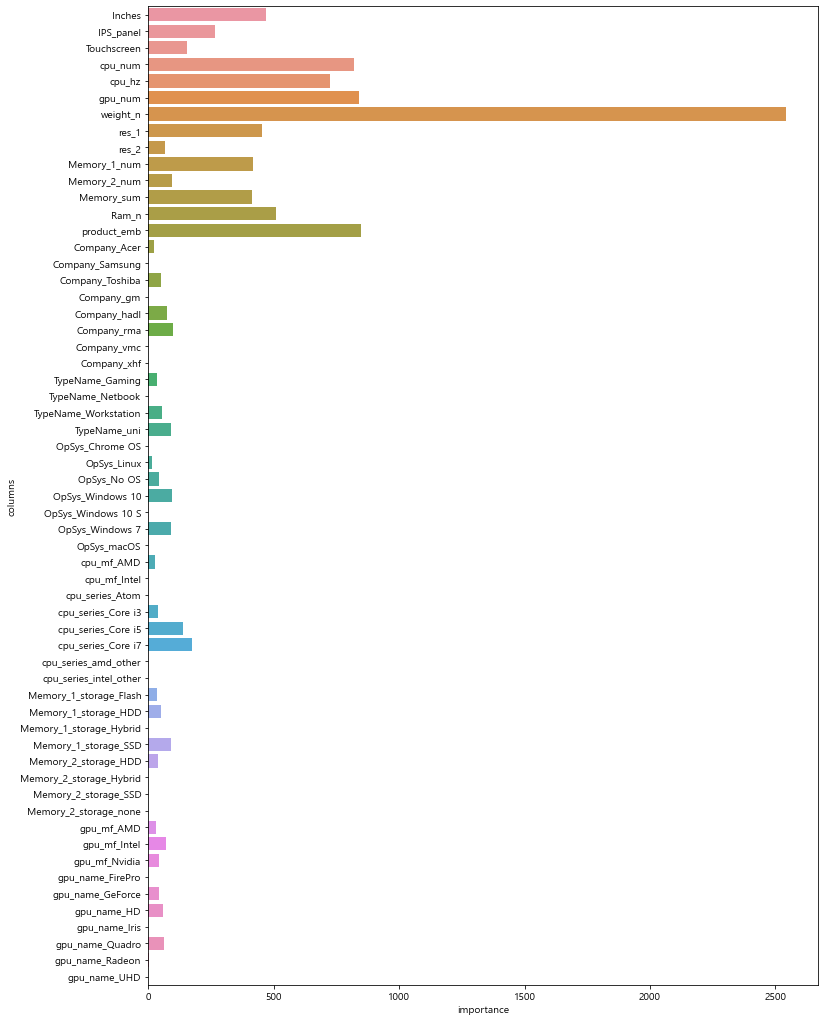

In [269]:
# feature importance 확인
lgbm_reg.fit(X_train, y_train)

temp_df = pd.DataFrame({'columns': X_train.columns, 
             'importance': lgbm_reg.feature_importances_})
plt.figure(figsize=(12, 18))
sns.barplot(x='importance', y = 'columns', data=temp_df)

**오차가 큰 데이터 확인**

In [192]:
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_test)

mean_squared_error(y_pred, y_test)

55217.61777944345

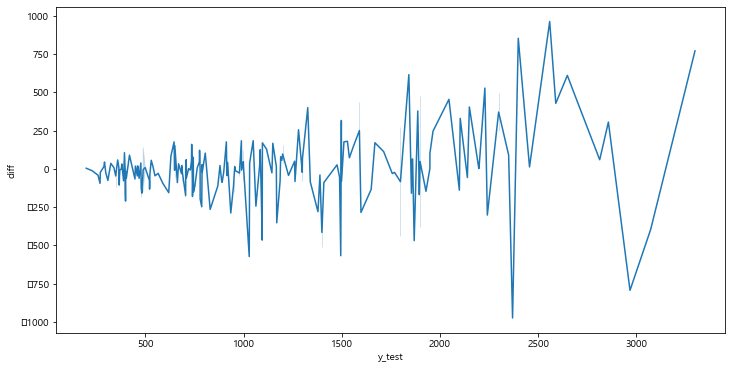

In [193]:
import seaborn as sns

score_df = pd.DataFrame({'y_test':y_test, 'y_pred':y_pred})
score_df['diff'] = score_df['y_test'] - score_df['y_pred']
plt.figure(figsize=(12, 6))
sns.lineplot(x='y_test', y='diff', data=score_df)

In [194]:
train.iloc[score_df[score_df['diff'] >= 500].index]

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,price
626,MSI,GT72S Dominator,Gaming,17.3,Full HD 1920x1080,Intel Core i7 6820HQ 2.7GHz,16GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 980M,Windows 10,3.78kg,2399.00
118,HP,EliteBook x360,2 in 1 Convertible,13.3,Full HD / Touchscreen 1920x1080,Intel Core i7 7600U 2.8GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.28kg,2559.00
492,HP,ZBook 15,Workstation,15.6,IPS Panel Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,8GB,256GB SSD,Nvidia Quadro M1000M,Windows 7,2.59kg,2229.00
141,Lenovo,Thinkpad P51s,Workstation,15.6,IPS Panel 4K Ultra HD 3840x2160,Intel Core i7 7600U 2.8GHz,16GB,1TB SSD,Nvidia Quadro M520M,Windows 10,2.5kg,3299.00
663,Dell,Latitude 7390,Ultrabook,13.3,Full HD / Touchscreen 1920x1080,Intel Core i5 8250U 1.6GHz,8GB,256GB SSD,Intel UHD Graphics 620,Windows 10,1.42kg,1841.85
377,Dell,XPS 13,Ultrabook,13.3,Quad HD+ / Touchscreen 3200x1800,Intel Core i7 7500U 2.7GHz,16GB,512GB SSD,Intel HD Graphics 620,Windows 10,1.2kg,2680.00
509,MSI,GS73VR Stealth,Gaming,17.3,IPS Panel 4K Ultra HD 3840x2160,Intel Core i7 6700HQ 2.6GHz,16GB,512GB SSD + 2TB HDD,Nvidia GeForce GTX 1060,Windows 10,2.43kg,2649.00


# 5. Test set 예측

In [195]:
test_df = pd.read_csv('Adv_IMC_test.csv')
test_df.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
0,Toshiba,Portege X30-D-10J,Notebook,13.3,IPS Panel Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.05kg
1,HP,Spectre 13-V100nv,Notebook,13.3,IPS Panel Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.11kg
2,Lenovo,IdeaPad 310-15ABR,Notebook,15.6,Full HD 1920x1080,AMD A10-Series 9600P 2.4GHz,6GB,1TB HDD,AMD Radeon R5 430,Windows 10,2.4kg
3,Lenovo,IdeaPad Y700-15ISK,Notebook,15.6,IPS Panel Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,8GB,1TB HDD,Nvidia GeForce GTX 960M,Windows 10,2.6kg
4,HP,EliteBook 820,Ultrabook,12.5,1366x768,Intel Core i5 6200U 2.3GHz,4GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.26kg


In [196]:
# Product 컬럼 제품명 추출
test_df['Product'] = test_df['Product'].str.lower()
test_df['Product'] = test_df['Product'].str.split(' ').str[0]
test_df['Product'] = test_df['Product'].str.split('-').str[0]

temp_list = []
for n in range(len(test_df)):
    if test_df.iloc[n]['Company'] in ['Asus', 'MSI', 'Lenovo', 'Acer', 'Mediacom', 'Vero'] and test_df.iloc[n]['Company'] != 'HP':
        product = test_df.iloc[n]['Product']
        num = re.findall('\d', product)
        if num != []:
            num = re.findall('\d', product)[0]
            result = product.split(num)[0]
        else:
            result = test_df.iloc[n]['Product']
    else:
        result = test_df.iloc[n]['Product']
    temp_list.append(result)
    
test_df['Product'] = pd.Series(temp_list)

# ScreenResolution 변수 전처리
test_df['ScreenResolution'] = test_df['ScreenResolution'].str.lower()
test_df['resolution_pixel'] = test_df['ScreenResolution'].str.split(' ').str[-1]
test_df['IPS_panel'] = test_df['ScreenResolution'].str.contains('ips panel').astype('int')
test_df['Touchscreen'] = test_df['ScreenResolution'].str.contains('touchscreen').astype('int')

# CPU 변수 전처리
test_df['cpu_mf'] = test_df['Cpu'].str.split(' ').str[0]
test_df['cpu_series'] = test_df['Cpu'].apply(get_series)
test_df['cpu_num'] = test_df['Cpu'].str.extract(r'(\d{4})')
test_df['cpu_hz'] = test_df['Cpu'].str.split(' ').str[-1]
test_df['cpu_hz'] = test_df['cpu_hz'].str.split('GHz').str[0]
test_df['cpu_hz'] = test_df['cpu_hz'].astype('float')
test_df.drop(test_df[test_df['cpu_mf'] == 'Samsung'].index, axis=0, inplace=True)

# Memory 변수 전처리
test_df['Memory_1'] = test_df['Memory'].str.split('+').str[0]
test_df['Memory_2'] = test_df['Memory'].str.split('+').str[1].str.strip()
test_df['Memory_1_capacity'] = test_df['Memory_1'].str.split(' ').str[0]
test_df['Memory_1_storage'] = test_df['Memory_1'].str.split(' ').str[1]
test_df['Memory_2_capacity'] = test_df['Memory_2'].str.split(' ').str[0]
test_df['Memory_2_storage'] = test_df['Memory_2'].str.split(' ').str[1]

# GPU 변수 전처리
test_df['gpu_mf'] = test_df['Gpu'].str.split(' ').str[0]
test_df['gpu_name'] = test_df['Gpu'].str.split(' ').str[1]
test_df['gpu_num'] = test_df['Gpu'].str.extract(r'(\d{3,4})')

# Weight 변수 전처리
test_df['weight_n'] = test_df['Weight'].str.split('kg').str[0].astype('float')

# ScreenResolution, Cpu, Memory, Memory_1, 2, Gpu, Weight 컬럼 drop
test_df = test_df.drop(['ScreenResolution', 'Cpu', 'Memory', 'Memory_1', 'Memory_2', 'Gpu', 'Weight'], axis=1)

# 데이터 타입 변환
test_df['cpu_num'] = test_df['cpu_num'].astype('float'); test_df['gpu_num'] = test_df['gpu_num'].astype('float')

# 제조사 samsung 인 열 drop
test_df.drop(test_df[test_df['cpu_mf'] == 'Samsung'].index, axis=0, inplace=True)

test_df.head()

,Company,Product,TypeName,Inches,Ram,OpSys,resolution_pixel,IPS_panel,Touchscreen,cpu_mf,cpu_series,cpu_num,cpu_hz,Memory_1_capacity,Memory_1_storage,Memory_2_capacity,Memory_2_storage,gpu_mf,gpu_name,gpu_num,weight_n
0,Toshiba,portege,Notebook,13.3,8GB,Windows 10,1920x1080,1,0,Intel,Core i5,7200.0,2.5,256GB,SSD,NaN,NaN,Intel,HD,620.0,1.05
1,HP,spectre,Notebook,13.3,8GB,Windows 10,1920x1080,1,0,Intel,Core i5,7200.0,2.5,256GB,SSD,NaN,NaN,Intel,HD,620.0,1.11
2,Lenovo,ideapad,Notebook,15.6,6GB,Windows 10,1920x1080,0,0,AMD,amd_other,9600.0,2.4,1TB,HDD,NaN,NaN,AMD,Radeon,430.0,2.40
3,Lenovo,ideapad,Notebook,15.6,8GB,Windows 10,1920x1080,1,0,Intel,Core i7,6700.0,2.6,1TB,HDD,NaN,NaN,Nvidia,GeForce,960.0,2.60
4,HP,elitebook,Ultrabook,12.5,4GB,Windows 10,1366x768,0,0,Intel,Core i5,6200.0,2.3,256GB,SSD,NaN,NaN,Intel,HD,520.0,1.26


In [197]:
# resolution_pixel 컬럼의 숫자 추출
test_df['res_1'] = test_df['resolution_pixel'].str.split('x').str[0]
test_df['res_2'] = test_df['resolution_pixel'].str.split('x').str[1]
test_df['res_1'] = test_df['res_1'].astype('int'); test_df['res_2'] = test_df['res_2'].astype('int') # data type 변경

In [198]:
# 먼저 Memory_2의 capacity, storage 변수의 결측치는 'none'으로 처리
test_df['Memory_2_capacity'].fillna('none', inplace=True) 
test_df['Memory_2_storage'].fillna('none', inplace=True)

In [199]:
test_df['Memory_1_num'] = test_df['Memory_1_capacity'].apply(memory_trans)
test_df['Memory_2_num'] = test_df['Memory_2_capacity'].apply(memory_trans)
test_df['Memory_sum'] = test_df['Memory_1_num'] + test_df['Memory_2_num']

In [200]:
# 숫자만 추출
test_df['Ram_n'] = test_df['Ram'].str.split('GB').str[0]

# 데이터 type 변경
test_df['Ram_n'] = test_df['Ram_n'].astype('int')

In [201]:
test_df['TypeName'] = test_df['TypeName'].apply(lambda x: 'uni' if x in ['Notebook', 'Ultrabook', '2 in 1 Convertible'] else x)

In [202]:
test_df['Company'] = test_df['Company'].apply(company_embeding)
test_df.head()

,Company,Product,TypeName,Inches,Ram,OpSys,resolution_pixel,IPS_panel,Touchscreen,cpu_mf,cpu_series,cpu_num,cpu_hz,Memory_1_capacity,Memory_1_storage,Memory_2_capacity,Memory_2_storage,gpu_mf,gpu_name,gpu_num,weight_n,res_1,res_2,Memory_1_num,Memory_2_num,Memory_sum,Ram_n
0,Toshiba,portege,uni,13.3,8GB,Windows 10,1920x1080,1,0,Intel,Core i5,7200.0,2.5,256GB,SSD,none,none,Intel,HD,620.0,1.05,1920,1080,256,0,256,8
1,hadl,spectre,uni,13.3,8GB,Windows 10,1920x1080,1,0,Intel,Core i5,7200.0,2.5,256GB,SSD,none,none,Intel,HD,620.0,1.11,1920,1080,256,0,256,8
2,hadl,ideapad,uni,15.6,6GB,Windows 10,1920x1080,0,0,AMD,amd_other,9600.0,2.4,1TB,HDD,none,none,AMD,Radeon,430.0,2.40,1920,1080,1000,0,1000,6
3,hadl,ideapad,uni,15.6,8GB,Windows 10,1920x1080,1,0,Intel,Core i7,6700.0,2.6,1TB,HDD,none,none,Nvidia,GeForce,960.0,2.60,1920,1080,1000,0,1000,8
4,hadl,elitebook,uni,12.5,4GB,Windows 10,1366x768,0,0,Intel,Core i5,6200.0,2.3,256GB,SSD,none,none,Intel,HD,520.0,1.26,1366,768,256,0,256,4


In [203]:
test_df['product_emb'] = test_df['Product'].apply(product_embedding)

vc_product = test_df['product_emb'].value_counts()
trans_num = vc_product[vc_product == vc_product.max()].index.values[0]
test_df['product_emb'] = test_df['product_emb'].replace(21, trans_num)

test_df.head()

,Company,Product,TypeName,Inches,Ram,OpSys,resolution_pixel,IPS_panel,Touchscreen,cpu_mf,cpu_series,cpu_num,cpu_hz,Memory_1_capacity,Memory_1_storage,Memory_2_capacity,Memory_2_storage,gpu_mf,gpu_name,gpu_num,weight_n,res_1,res_2,Memory_1_num,Memory_2_num,Memory_sum,Ram_n,product_emb
0,Toshiba,portege,uni,13.3,8GB,Windows 10,1920x1080,1,0,Intel,Core i5,7200.0,2.5,256GB,SSD,none,none,Intel,HD,620.0,1.05,1920,1080,256,0,256,8,0
1,hadl,spectre,uni,13.3,8GB,Windows 10,1920x1080,1,0,Intel,Core i5,7200.0,2.5,256GB,SSD,none,none,Intel,HD,620.0,1.11,1920,1080,256,0,256,8,7
2,hadl,ideapad,uni,15.6,6GB,Windows 10,1920x1080,0,0,AMD,amd_other,9600.0,2.4,1TB,HDD,none,none,AMD,Radeon,430.0,2.40,1920,1080,1000,0,1000,6,2
3,hadl,ideapad,uni,15.6,8GB,Windows 10,1920x1080,1,0,Intel,Core i7,6700.0,2.6,1TB,HDD,none,none,Nvidia,GeForce,960.0,2.60,1920,1080,1000,0,1000,8,2
4,hadl,elitebook,uni,12.5,4GB,Windows 10,1366x768,0,0,Intel,Core i5,6200.0,2.3,256GB,SSD,none,none,Intel,HD,520.0,1.26,1366,768,256,0,256,4,7


In [205]:
test_df.drop(['Ram', 'resolution_pixel', 'Memory_1_capacity', 'Memory_2_capacity', 'Product'], 
              axis=1, inplace=True)
test_df.head()

,Company,TypeName,Inches,OpSys,IPS_panel,Touchscreen,cpu_mf,cpu_series,cpu_num,cpu_hz,Memory_1_storage,Memory_2_storage,gpu_mf,gpu_name,gpu_num,weight_n,res_1,res_2,Memory_1_num,Memory_2_num,Memory_sum,Ram_n,product_emb
0,Toshiba,uni,13.3,Windows 10,1,0,Intel,Core i5,7200.0,2.5,SSD,none,Intel,HD,620.0,1.05,1920,1080,256,0,256,8,0
1,hadl,uni,13.3,Windows 10,1,0,Intel,Core i5,7200.0,2.5,SSD,none,Intel,HD,620.0,1.11,1920,1080,256,0,256,8,7
2,hadl,uni,15.6,Windows 10,0,0,AMD,amd_other,9600.0,2.4,HDD,none,AMD,Radeon,430.0,2.40,1920,1080,1000,0,1000,6,2
3,hadl,uni,15.6,Windows 10,1,0,Intel,Core i7,6700.0,2.6,HDD,none,Nvidia,GeForce,960.0,2.60,1920,1080,1000,0,1000,8,2
4,hadl,uni,12.5,Windows 10,0,0,Intel,Core i5,6200.0,2.3,SSD,none,Intel,HD,520.0,1.26,1366,768,256,0,256,4,7


In [206]:
test_df['product_emb'] = test_df['product_emb'].astype('str')
test_df = pd.get_dummies(test_df)
print(test_df.shape)

# 최종 데이터
test_df.head()

(261, 66)


,Inches,IPS_panel,Touchscreen,cpu_num,cpu_hz,gpu_num,weight_n,res_1,res_2,Memory_1_num,Memory_2_num,Memory_sum,Ram_n,Company_Acer,Company_Samsung,Company_Toshiba,Company_gm,Company_hadl,Company_rma,Company_vmc,...,Memory_2_storage_SSD,Memory_2_storage_none,gpu_mf_AMD,gpu_mf_Intel,gpu_mf_Nvidia,gpu_name_FirePro,gpu_name_GeForce,gpu_name_HD,gpu_name_Iris,gpu_name_Quadro,gpu_name_Radeon,gpu_name_UHD,product_emb_0,product_emb_1,product_emb_2,product_emb_4,product_emb_5,product_emb_6,product_emb_7,product_emb_9
0,13.3,1,0,7200.0,2.5,620.0,1.05,1920,1080,256,0,256,8,0,0,1,0,0,0,0,...,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
1,13.3,1,0,7200.0,2.5,620.0,1.11,1920,1080,256,0,256,8,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2,15.6,0,0,9600.0,2.4,430.0,2.40,1920,1080,1000,0,1000,6,0,0,0,0,1,0,0,...,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,15.6,1,0,6700.0,2.6,960.0,2.60,1920,1080,1000,0,1000,8,0,0,0,0,1,0,0,...,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
4,12.5,0,0,6200.0,2.3,520.0,1.26,1366,768,256,0,256,4,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


In [207]:
submission_y = pd.DataFrame(xgb_reg.predict(test_df))
submission_y.to_csv('submission.csv',index=False)

In [208]:
test_df['y'] = submission_y
test_df.head()

,Inches,IPS_panel,Touchscreen,cpu_num,cpu_hz,gpu_num,weight_n,res_1,res_2,Memory_1_num,Memory_2_num,Memory_sum,Ram_n,Company_Acer,Company_Samsung,Company_Toshiba,Company_gm,Company_hadl,Company_rma,Company_vmc,...,Memory_2_storage_none,gpu_mf_AMD,gpu_mf_Intel,gpu_mf_Nvidia,gpu_name_FirePro,gpu_name_GeForce,gpu_name_HD,gpu_name_Iris,gpu_name_Quadro,gpu_name_Radeon,gpu_name_UHD,product_emb_0,product_emb_1,product_emb_2,product_emb_4,product_emb_5,product_emb_6,product_emb_7,product_emb_9,y
0,13.3,1,0,7200.0,2.5,620.0,1.05,1920,1080,256,0,256,8,0,0,1,0,0,0,0,...,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1349.988281
1,13.3,1,0,7200.0,2.5,620.0,1.11,1920,1080,256,0,256,8,0,0,0,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1293.171631
2,15.6,0,0,9600.0,2.4,430.0,2.40,1920,1080,1000,0,1000,6,0,0,0,0,1,0,0,...,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,430.376923
3,15.6,1,0,6700.0,2.6,960.0,2.60,1920,1080,1000,0,1000,8,0,0,0,0,1,0,0,...,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,889.072327
4,12.5,0,0,6200.0,2.3,520.0,1.26,1366,768,256,0,256,4,0,0,0,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1373.279297
